# AM Acoustic Signal Classification with Deep Learning
Classifying AM process anomalies from recorded audio signal

- Author： Chen Lequn
- A comprehensive analysis on additive manufacturing (DED) acoustic signal.
- System requirement: Python3, Librosa, Scikit-learn, Keras, etc.

## **Notebook 7(a): Modeling - MFCC features with Convolutional Neural Network (CNN)**

## Importing Libraries

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [4]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print(device_lib.list_local_devices())

Num GPUs Available:  1


In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [6]:
# Once all this is done your model will run on GPU:
# To Check if keras(>=2.1.1) is using GPU:
# from tensorflow import keras
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [8]:
import pandas as pd
import numpy as np
from itertools import cycle
import datetime

## plot
import matplotlib.pyplot as plt
import seaborn as sns

## others
#from glob import glob
import itertools
import os

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc

## keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

#To visualize the whole grid
pd.options.display.max_columns = 999

%matplotlib inline
%pylab inline
font = {
    # 'family' : 'normal',
        # 'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [9]:
# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"
Audio_PATH_original = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'wave_file', "original", 'train')
Audio_PATH_original_seg = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'wave_file', "original", "train_seg")
Audio_PATH_equalized = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'wave_file', "equalized")
Audio_PATH_bandpassed = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'wave_file', "bandpassed")
Audio_PATH_denoised = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset",'wave_file', "denoised", 'train')

Audio_PATH_original_layer = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'wave_file', "original", "sliced_layers")
Audio_PATH_equalized_layer = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'wave_file', "equalized", "sliced_layers")
Audio_PATH_bandpass_layer = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset",  'wave_file', "bandpassed", "sliced_layers")
Audio_PATH_denoised_layer = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset",  'wave_file', "denoised", "sliced_layers")

Audio_PATH_original_segmented = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'wave_file', "segment", "original") 
Audio_PATH_equalized_segmented = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset",  'wave_file', "segment", "equalized")  
Audio_PATH_bandpassed_segmented = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset",  'wave_file', "segment", "bandpassed")
Audio_PATH_denoised_segmented = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset",  'wave_file', "segment", "denoised")


label_file = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'wave_file', 'label.csv')

Experiment_PATH = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset")
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", "DL", "MFCC-CNN")
os.makedirs(Audio_PATH_original, exist_ok=True)
os.makedirs(Audio_PATH_original_seg, exist_ok=True)
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [10]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [11]:
sys.path.insert(0, '../utils')
import glob
import utils
import filter
import feature_extractions
import utils_deeplearning

# MFCC-CNN Modelling
## Baseline Accuracy

The baseline accuracy in this multi-class classificiation problem is **xxx%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [12]:
df_dataset_original = pd.read_csv("../outputs/df_dataset_original.csv")

### Get the percentage distribution of each category
round(df_dataset_original.groupby('Label')["Label"].count()/df_dataset_original.shape[0]*100, 1)

Label
Cracks           31.7
Defect-free      38.6
Keyhole pores    29.7
Name: Label, dtype: float64

**2D Convolutional Neural Networks**

- Starting with a sequential model so we can build the model layer by layer.
- The model consists of **3 x "convolutional + pooling layer"**, then a fully connected layer. 
- The input is the 20 mfccs with 130 frames. Each convolutional layer have different number of convolutional filters. Max pooling is used and **dropout** of 20% on the 2nd and 3rd convolutional layer is applied to reduce over-fitting.
- Then, **flatten** the layer before passing it to fully connected dense layer.
- It has **1 dense layer** with 128 neurons and 50% dropout is applied as well for better generalisation and reduce overfit on the training data.
- The final **output layer have 3 neurons**, which is the **3 categories** that would like the model to classify the audio. The activiation for all the layers is 'relu' and 'softmax' at the final layer. **Softmax** makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.

## 7.1 X_train (1-s segment, original dataset)
Initial training

In [20]:
### Load preprocess data and features from previous notebook

%store -r X_train_original 
%store -r X_test_original 
%store -r y_train_original
%store -r y_test_original 
%store -r le
%store -r class_weights_original

In [13]:
X_train_original.shape

(1000, 20, 87, 1)

In [14]:
le.classes_

array(['Cracks', 'Defect-free', 'Keyhole pores'], dtype=object)

In [15]:
class_weights_original

array([0.93632959, 0.90334237, 1.21212121])

In [15]:
X_train_original.shape

(1000, 20, 87, 1)

In [16]:
### Build CNN model
model = Sequential()

# add 1st convolutional layer
model.add(Conv2D(filters = 32, kernel_size = 5, activation = 'relu', padding = 'same',
                 input_shape = (X_train_original.shape[1], X_train_original.shape[2], X_train_original.shape[3])))
model.add(MaxPooling2D())

# add 2nd convolutional layer
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

# add 3rd convolutional layer
model.add(Conv2D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

# flatten results so that it can pass to dense layer
model.add(Flatten())

# add dense layer with 128 neurons
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
# add final layer with 3 neurons(3 label)
model.add(Dense(len(le.classes_), activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 20, 87, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 43, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 43, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 21, 64)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 21, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 21, 128)        204928    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 10, 128)       

### Compile Model

In [18]:
Ad = optimizers.Adam(learning_rate=0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer= Ad, metrics = ['accuracy'])

### Fit Model

In [21]:
history_original_initial = model.fit(X_train_original, y_train_original, validation_data = (X_test_original, y_test_original),
                    epochs = 200, verbose = 2) #class_weight=class_weights batch_size = 5,

# history = model.fit(X_train_0, y_train_0, epochs = 100, batch_size = 5, validation_data = (X_test, y_test))

Epoch 1/200
32/32 - 0s - loss: 0.2796 - accuracy: 0.8780 - val_loss: 0.4550 - val_accuracy: 0.8327
Epoch 2/200
32/32 - 0s - loss: 0.2919 - accuracy: 0.8790 - val_loss: 0.4329 - val_accuracy: 0.8287
Epoch 3/200
32/32 - 0s - loss: 0.2754 - accuracy: 0.8760 - val_loss: 0.4196 - val_accuracy: 0.8327
Epoch 4/200
32/32 - 0s - loss: 0.2797 - accuracy: 0.8800 - val_loss: 0.4358 - val_accuracy: 0.8327
Epoch 5/200
32/32 - 0s - loss: 0.2852 - accuracy: 0.8870 - val_loss: 0.4053 - val_accuracy: 0.8446
Epoch 6/200
32/32 - 0s - loss: 0.2769 - accuracy: 0.8860 - val_loss: 0.4127 - val_accuracy: 0.8367
Epoch 7/200
32/32 - 0s - loss: 0.2722 - accuracy: 0.8870 - val_loss: 0.4252 - val_accuracy: 0.8327
Epoch 8/200
32/32 - 0s - loss: 0.2821 - accuracy: 0.8780 - val_loss: 0.4370 - val_accuracy: 0.8247
Epoch 9/200
32/32 - 0s - loss: 0.2797 - accuracy: 0.8810 - val_loss: 0.4229 - val_accuracy: 0.8327
Epoch 10/200
32/32 - 0s - loss: 0.2789 - accuracy: 0.8800 - val_loss: 0.4353 - val_accuracy: 0.8327
Epoch 11/

### Evaluate the Loss and Accuracy Score

In [13]:
### Define Loss and Accuracy plot function
def loss_acc_plot(historyname, epochs_num, title, interval=20, yloss_limit1=0, yloss_limit2=1.5, yacc_limit1=0.4, yacc_limit2=1):
    fig, (ax1,ax2) = plt.subplots(nrows = 2, sharex = True, figsize=(7,8));
    # plt.title(title, fontsize = 20, y=1.05)
    # Loss plot
    ax1.plot(historyname.history['loss'], 'darkorange', label = 'Train Loss', linewidth=2)
    ax1.plot(historyname.history['val_loss'], 'navy', label = 'Test Loss', linewidth=2)
    ax1.legend(loc =1, fontsize = 16)
    ax1.set_xlabel('Epochs', fontsize = 20)
    ax1.set_xticks(np.arange(0,epochs_num+1,interval))
    ax1.set_ylabel('Crossentropy Loss', fontsize = 20)
    ax1.set_ylim(yloss_limit1,yloss_limit2)
    ax1.set_title('Loss Curve', fontsize = 20, pad=12)
    ax1.xaxis.set_tick_params(labelsize=18)
    ax1.yaxis.set_tick_params(labelsize=18)
    
    # Accuracy plot
    ax2.plot(historyname.history['accuracy'], 'darkorange', label = 'Train Accuracy', linewidth=2)
    ax2.plot(historyname.history['val_accuracy'], 'navy', label = 'Test Accuracy', linewidth=2)
    ax2.legend(loc =4, fontsize = 16)
    ax2.set_xlabel('Epochs', fontsize = 20)
    ax1.set_xticks(np.arange(0,epochs_num+1,interval))
    ax2.set_ylabel('Accuracy', fontsize =20)
    ax2.set_ylim(yacc_limit1,yacc_limit2)
    ax2.set_title('Accuracy Curve', fontsize =20, pad=12)
    ax2.xaxis.set_tick_params(labelsize=18)
    ax2.yaxis.set_tick_params(labelsize=18)
    ax1.grid(zorder=3, linestyle='--',linewidth=0.8, alpha=0.4, color = "k") #linestyle='--', color='r'
    ax2.grid(zorder=3, linestyle='--',linewidth=0.8, alpha=0.4, color = "k") #linestyle='--', color='r'
    # fig.suptitle(title, fontsize = 22, y=1.001)
    
    plt.tight_layout()
    
### Define Loss and Accuracy plot function
def test_accuracy_plot(historyname, epochs_num, title, interval=20, yloss_limit1=0, yloss_limit2=1.5, yacc_limit1=0.4, yacc_limit2=1):
    fig, ax = plt.subplots(nrows = 1, sharex = True, figsize=(7,4));
    
    # Accuracy plot
    # ax2.plot(historyname.history['accuracy'], 'darkorange', label = 'Train Accuracy', linewidth=2)
    ax.plot(historyname.history['val_accuracy'], 'navy', label = 'Test Accuracy', linewidth=2)
    ax.legend(loc =4, fontsize = 16)
    ax.set_xlabel('Epochs', fontsize = 18)
    ax.set_xticks(np.arange(0,epochs_num+1,interval))
    ax.set_ylabel('Test accuracy', fontsize =18)
    ax.set_ylim(yacc_limit1,yacc_limit2)
    ax.set_title('Accuracy Curve', fontsize =20, pad=12)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.grid(zorder=3, linestyle='--',linewidth=0.8, alpha=0.4, color = "k") #linestyle='--', color='r'
    # fig.suptitle(title, fontsize = 22, y=1.001)
    
    plt.tight_layout()
    

In [18]:
### Plot Loss & Accuracy curve
loss_acc_plot(history_original_initial, 200, 'MFCC-CNN original (initial)', yloss_limit1= 0, yloss_limit2=1.5, yacc_limit1=0.3, yacc_limit2=1, interval=50)
save_fig("MFCC_CNN_original_trainining - initial")

NameError: name 'history_original_initial' is not defined

Overfiting, so need add regularization

In [14]:
### Function to print out the model's loss and accuracy score
def xtest_loss_acc(modelname, X_test, y_test):
    
    model_score = modelname.evaluate(X_test, y_test, verbose =2)
    model_labels = modelname.metrics_names
    
    print(f"cnn {model_labels[0]}: {round(model_score[0] ,5)}")
    print(f"cnn {model_labels[1]}: {round(model_score[1] ,5)}")

In [20]:
xtest_loss_acc(model, X_test_original, y_test_original)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

### Model Prediction and evaluation on test set

In [15]:
### Define function to predict X_test, return y_pred & y_true and print the classification report
def class_report(modelname, X_test, y_test, le):
    ### predict the X_test
    # pred = modelname.predict_classes(X_test) # deprecated
    predict_x=modelname.predict(X_test) 
    pred=np.argmax(predict_x,axis=1)
    
    # compile predicted results
    y_true, y_pred = [], []
    classes = le.classes_
    
    for idx, preds in enumerate(pred):
        y_true.append(classes[np.argmax(y_test[idx])])
        y_pred.append(classes[preds])
    
    print(classification_report(y_true, y_pred,digits=4))
    return y_true, y_pred

### Model (preliminary) Evaluation Summary

To evaluate the effectiveness of the classification model, metrics used to assess are:

1. **$Precision = TP/(FP+TP)$**

**Precision** provides the *positive predictive value, the proportion of samples that belong in category $x$ that are correctly placed in category $x$*. Example, among all predicted defect, how many did I predict correctly? High precision is with low FP (predict to be cracks but actually is not).

2. **$f1 = 2*(Precision*Recall)/(Precision + Recall)$**

**Weighted average for precision and recall**. This score takes both FN and FP into account as $Recall = TP/(FN+TP)$. This is better metric for evaluating an uneven class distribution problem, which is the case in this project. 

3. $Accuracy = (TP+TN)/(All predict)$

Model achieve pretty high **>80%** overall accuracy.

The model able to classify well for defects sounds. However, it did badly on the detecting ***cracks***

- In conclusion, the initial model without Hyper-parameter tuning did pretty well in general. But it does not outperform the traditional ML algorithms. And it did poorly in classifying the cracking regimes.

In [26]:
yt_initial, yp_initial = class_report(model, X_test_original, y_test_original, le)

               precision    recall  f1-score   support

       Cracks     0.7037    0.8539    0.7716        89
  Defect-free     0.9268    0.8172    0.8686        93
Keyhole pores     0.8689    0.7681    0.8154        69

     accuracy                         0.8167       251
    macro avg     0.8331    0.8131    0.8185       251
 weighted avg     0.8318    0.8167    0.8196       251



### Category/ label that was wrongly classified by the model

In [27]:
### View the class with WRONG classificaiton 
cnn_pred_result = list(zip(yt_initial, yp_initial))
cnn_result_df = pd.DataFrame(cnn_pred_result, columns = ['label', 'pred_label'])
cnn_result_df[cnn_result_df['label'] != cnn_result_df['pred_label']]

,label,pred_label
3,Defect-free,Cracks
5,Defect-free,Cracks
7,Defect-free,Cracks
18,Defect-free,Cracks
24,Defect-free,Cracks
25,Keyhole pores,Cracks
30,Cracks,Defect-free
31,Defect-free,Cracks
34,Cracks,Keyhole pores
39,Cracks,Keyhole pores


### Confusion Matrix

In [16]:
### Function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7,7))
    im_ratio = cm.shape[1]/cm.shape[0]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20, pad=12)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.3f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize = 16, 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth', fontsize=20, labelpad =8)
    plt.xlabel('Predicted', fontsize=20, labelpad =12)
    plt.xticks(fontsize=16,  rotation=45, ha='right')
    plt.yticks(fontsize=16)
    cbar = plt.colorbar(orientation="vertical", pad=0.1, ticks=[0.1, 0.4,0.7, 0.8, 0.9],fraction=0.045*im_ratio)
    plt.clim(0,0.95)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('Accuracy',fontsize=16, pad = 12)
    plt.tight_layout()

    # plt.show()
    
def plot_confusion_matrix_sns(y_true, y_pred, classes):
    plt.figure(figsize=(10, 7))
    tick_marks = np.arange(len(classes))
    cm = confusion_matrix(y_true, y_pred)
    # convert to percentage and plot the confusion matrix
    cm_pct = cm.astype(float) / cm.sum(axis =1)[:,np.newaxis]
    sns.heatmap(cm_pct, annot=True, fmt='.3%', cmap='Blues', linewidths=2, linecolor='black') #cmap='Blues'
    plt.xticks(tick_marks, classes, horizontalalignment='center', rotation=70, fontsize=12)
    plt.yticks(tick_marks, classes, horizontalalignment="center", rotation=0, fontsize=12)
#     ax.set_xticklabels(
# #     ax.get_xticklabels(),
# #     # rotation=45,
# #     # horizontalalignment='right',
# #     fontsize = 2
# # )
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    

In [17]:
## Define function to get the confusion matrix and print out the plot as well

def conf_matrix(y_true, y_pred, le):
    cm = confusion_matrix(y_true, y_pred)
    
    # convert to percentage and plot the confusion matrix
    cm_pct = cm.astype(float) / cm.sum(axis =1)[:,np.newaxis]
    
    classes = le.classes_
    print(cm)
    plot_confusion_matrix(cm_pct, classes)

[[76  5  8]
 [17 76  0]
 [15  1 53]]
Saving figure MFCC_CNN_confusion_matrix_original_initial


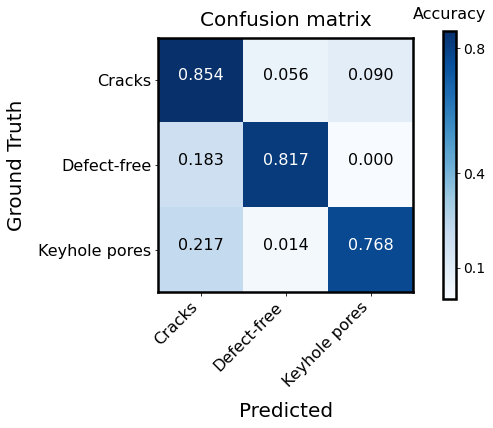

In [30]:
conf_matrix(yt_initial, yp_initial, le)
save_fig("MFCC_CNN_confusion_matrix_original_initial")

## 7.1.1 Hyperparameter Tuning with RandomSearchCV - original signal

In [21]:
### tentatively assign an input shape so that no error in the user define function below.
### MUST define input_shapes when apply the below function for RandomizedSearchCV
input_shapes = (X_train_original.shape[1], X_train_original.shape[2], X_train_original.shape[3])
classes = le.classes_

In [23]:
X_train_original.shape

(1000, 20, 87, 1)

In [22]:
### User defined model FUNCTION for RandomizedSearchCV
def model_funcs(
               filter_one = 16, kernel_size_one = 2, input_shapes=input_shapes,
               filter_two = 32, kernel_size_two = 2, dropout_two = 0.2,
               filter_three = 64, kernel_size_three = 2, dropout_three = 0.2,
               neurons = 128, dropout_four = 0.5,
               regularizer_rate = 0.1,
               opt_learning_rate = 0.0001):
    
    
    cnn = Sequential()
    
    # add 1st convolutional layer
    cnn.add(Conv2D(filters = filter_one, kernel_size = kernel_size_one, activation = 'relu', padding = 'same',
                  input_shape = input_shapes))
    cnn.add(MaxPooling2D())
    
    # add 2nd convolutional layer
    cnn.add(Conv2D(filters = filter_two, kernel_size = kernel_size_two, padding = 'same', activation = 'relu'))
    cnn.add(MaxPooling2D())
    cnn.add(Dropout(dropout_two))
    
    # add 3rd convolutional layer
    cnn.add(Conv2D(filters = filter_three, kernel_size = kernel_size_three, padding = 'same', activation = 'relu'))
    cnn.add(MaxPooling2D())
    cnn.add(Dropout(dropout_three))
    
    # flatten layer before passing to FC layer
    cnn.add(Flatten())
    
    # add densely connected layer
    cnn.add(Dense(neurons, activation = 'relu', kernel_regularizer = regularizers.l2(regularizer_rate)))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(dropout_four))
    
    # add output layer
    cnn.add(Dense(len(classes), activation = 'softmax'))
    
    # add optimizer
    Ad = optimizers.Adam(learning_rate = opt_learning_rate)
    
    # compile model
    cnn.compile(loss = 'categorical_crossentropy', optimizer= Ad, metrics = ['accuracy'])

    return cnn

In [34]:
### Set the hyperparameter for randomsearchCV

params = {
          'filter_one' : [16, 32], 'kernel_size_one' : [2,3,5,8],
          'filter_two' : [16,32,64], 'kernel_size_two' : [2,3,5], 'dropout_two': [0.2, 0.5],
          'filter_three' : [32, 64, 128], 'kernel_size_three' : [2,3,5], 'dropout_three': [0.2, 0.5],
          'neurons' : [64, 128, 256], 'dropout_four': [0.2, 0.5],
          'regularizer_rate' : [0.1, 0.05, 0.01],
          'opt_learning_rate' : [0.01, 0.001, 0.0001]
          # 'batch_size' = [20]
         }

# lambda_parameter = [0.01, 0.5, 1]
# epochs = [50, 100]
# batch_size = [20]
# param_grid = dict(lambda_parameter=lambda_parameter, epochs=epochs, 
# batch_size=batch_size)

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
# results_1 = grid_search.fit(X, y)

In [47]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [92]:
### Instantiate user defined function and run RandomizedSearchCV
input_shapes = (X_train_original.shape[1], X_train_original.shape[2], X_train_original.shape[3])

# nn = KerasClassifier(model = model_funcs, epochs = 50, 
#                     filter_one = 16, kernel_size_one = 2, input_shapes=input_shapes,
#                    filter_two = 16, kernel_size_two = 2, dropout_two = 0.2,
#                    filter_three = 32, kernel_size_three = 3, dropout_three = 0.2,
#                    neurons = 64, dropout_four = 0.5,
#                    regularizer_rate = 0.05,
#                    opt_learning_rate = 0.01)

nn = KerasClassifier(build_fn = model_funcs, epochs = 50, verbose = 2)
                

### Instantiate RandomizedSearchCV
rscv = RandomizedSearchCV(nn, param_distributions = params, cv = 5)
# rscv = GridSearchCV(nn, param_grid = params, cv = 5)
rscv.fit(X_train_original, y_train_original)

# model best estimators
print(f"best estimator: {rscv.best_params_}")
print(f"best score: {rscv.best_score_}")

Epoch 1/50
25/25 - 0s - loss: 2.6814 - accuracy: 0.3700
Epoch 2/50
25/25 - 0s - loss: 2.0017 - accuracy: 0.5038
Epoch 3/50
25/25 - 0s - loss: 1.5454 - accuracy: 0.5950
Epoch 4/50
25/25 - 0s - loss: 1.2581 - accuracy: 0.6025
Epoch 5/50
25/25 - 0s - loss: 1.0284 - accuracy: 0.6737
Epoch 6/50
25/25 - 0s - loss: 0.9248 - accuracy: 0.6862
Epoch 7/50
25/25 - 0s - loss: 0.9086 - accuracy: 0.6800
Epoch 8/50
25/25 - 0s - loss: 0.8712 - accuracy: 0.6787
Epoch 9/50
25/25 - 0s - loss: 0.8086 - accuracy: 0.6712
Epoch 10/50
25/25 - 0s - loss: 0.8607 - accuracy: 0.6787
Epoch 11/50
25/25 - 0s - loss: 0.8512 - accuracy: 0.6662
Epoch 12/50
25/25 - 0s - loss: 0.8208 - accuracy: 0.6913
Epoch 13/50
25/25 - 0s - loss: 0.8689 - accuracy: 0.6800
Epoch 14/50
25/25 - 0s - loss: 0.8130 - accuracy: 0.6875
Epoch 15/50
25/25 - 0s - loss: 0.8421 - accuracy: 0.6513
Epoch 16/50
25/25 - 0s - loss: 0.8345 - accuracy: 0.6725
Epoch 17/50
25/25 - 0s - loss: 0.8153 - accuracy: 0.6825
Epoch 18/50
25/25 - 0s - loss: 0.8301 - 

2022-11-08 14:54:22.341960: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-11-08 14:54:23.143411: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-11-08 14:54:23.932588: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-11-08 14:54:24.721495: W tensorflow/stream_executor/gpu/

7/7 - 36s - loss: 1.4198 - accuracy: 0.6950


2022-11-08 14:54:56.937961: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



Epoch 1/50
25/25 - 0s - loss: 6.4137 - accuracy: 0.4837
Epoch 2/50
25/25 - 0s - loss: 2.6756 - accuracy: 0.4875
Epoch 3/50
25/25 - 0s - loss: 2.1750 - accuracy: 0.5500
Epoch 4/50
25/25 - 0s - loss: 1.8770 - accuracy: 0.5925
Epoch 5/50
25/25 - 0s - loss: 1.5700 - accuracy: 0.6150
Epoch 6/50
25/25 - 0s - loss: 1.9638 - accuracy: 0.5725
Epoch 7/50
25/25 - 0s - loss: 1.6837 - accuracy: 0.6112
Epoch 8/50
25/25 - 0s - loss: 1.5127 - accuracy: 0.6125
Epoch 9/50
25/25 - 0s - loss: 1.4667 - accuracy: 0.6112
Epoch 10/50
25/25 - 0s - loss: 1.6518 - accuracy: 0.5938
Epoch 11/50
25/25 - 0s - loss: 1.9547 - accuracy: 0.5763
Epoch 12/50
25/25 - 0s - loss: 2.3934 - accuracy: 0.6112
Epoch 13/50
25/25 - 0s - loss: 1.8864 - accuracy: 0.5987
Epoch 14/50
25/25 - 0s - loss: 2.2906 - accuracy: 0.6075
Epoch 15/50
25/25 - 0s - loss: 1.5749 - accuracy: 0.6413
Epoch 16/50
25/25 - 0s - loss: 1.5258 - accuracy: 0.6538
Epoch 17/50
25/25 - 0s - loss: 1.9425 - accuracy: 0.5763
Epoch 18/50
25/25 - 0s - loss: 2.1389 - 

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f7b8b6675e0>
Traceback (most recent call last):
  File "/home/lequn/anaconda3/envs/simtech/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 
Exception ignored in: <function ScopedTFFunction.__del__ at 0x7f7c38065550>
Traceback (most recent call last):
  File "/home/lequn/anaconda3/envs/simtech/lib/python3.8/site-packages/tensorflow/python/framework/c_api_util.py", line 106, in __del__
    self.deleter(self.func)
KeyboardInterrupt: 

KeyboardInterrupt



In [93]:
### RandomizedSearchCV results

print(f" train score: {round(rscv.best_score_, 4)}")
print(f" test score: {round(rscv.score(X_test_original, y_test_original), 4)}")
print(f" best_parameters: {rscv.best_params_}")

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score_'

## 7.1.2 CNN with Optimal Hyperparameter
**X_train_original**

In [70]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [52]:
### Fit model
### based on the previously determined value
# filter_one, kernel_size_one, input_shapes,
# filter_two, kernel_size_two, dropout_two,
# filter_three, kernel_size_three, dropout_three,
# neurons, dropout_four, regularizer_rate,
# opt_learning_rate
# model_optimal_MFCCCNN_original = model_funcs(16, 3,(X_train_original.shape[1], X_train_original.shape[2], X_train_original.shape[3]) ,
#                     32, 2, 0.2,
#                     64, 5, 0.5,
#                     64, 0.2, 0.1,
#                     0.001)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                                        decay_steps=100,
                                                        decay_rate=0.999)



# log_dir = "logs/fit/" + "record_original"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# model_optimal_MFCCCNN_original = model_funcs(16, 2,(X_train_original.shape[1], X_train_original.shape[2], X_train_original.shape[3]) ,
#                                             16, 2, 0.2,
#                                              32, 3, 0.5,
#                                              256, 0.2, 0.1,
#                                              0.0001)

model_optimal_MFCCCNN_original = model_funcs(16, 5,(X_train_original.shape[1], X_train_original.shape[2], X_train_original.shape[3]) ,
                                            16, 2, 0.2,
                                             32, 3, 0.5,
                                             256, 0.2, 0.13,
                                             0.0001)


history_optimal_MFCCCNN_original = model_optimal_MFCCCNN_original.fit(X_train_original, y_train_original, 
                                                                      validation_data = (X_test_original, y_test_original),
                                                                      epochs = 2000, shuffle = True, verbose =2) #class_weight=class_weights

Epoch 1/2000
32/32 - 2s - loss: 46.8153 - accuracy: 0.3330 - val_loss: 44.2385 - val_accuracy: 0.2749
Epoch 2/2000
32/32 - 0s - loss: 42.5357 - accuracy: 0.3610 - val_loss: 40.2385 - val_accuracy: 0.3705
Epoch 3/2000
32/32 - 0s - loss: 38.6137 - accuracy: 0.3630 - val_loss: 36.5338 - val_accuracy: 0.3705
Epoch 4/2000
32/32 - 0s - loss: 34.9440 - accuracy: 0.3770 - val_loss: 33.1036 - val_accuracy: 0.3705
Epoch 5/2000
32/32 - 0s - loss: 31.5770 - accuracy: 0.4300 - val_loss: 29.9361 - val_accuracy: 0.3705
Epoch 6/2000
32/32 - 0s - loss: 28.4946 - accuracy: 0.4520 - val_loss: 27.0175 - val_accuracy: 0.4143
Epoch 7/2000
32/32 - 0s - loss: 25.6422 - accuracy: 0.5130 - val_loss: 24.3407 - val_accuracy: 0.5179
Epoch 8/2000
32/32 - 0s - loss: 23.0300 - accuracy: 0.5790 - val_loss: 21.8929 - val_accuracy: 0.5339
Epoch 9/2000
32/32 - 0s - loss: 20.6519 - accuracy: 0.5940 - val_loss: 19.6570 - val_accuracy: 0.5817
Epoch 10/2000
32/32 - 0s - loss: 18.5190 - accuracy: 0.5970 - val_loss: 17.6230 - 

Saving figure MFCC_CNN_Optimal_training_original


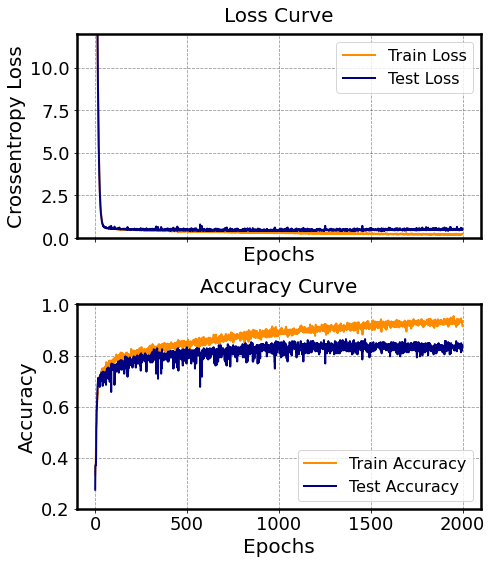

In [53]:
loss_acc_plot(history_optimal_MFCCCNN_original, 2000, 'MFCC-CNN (original)', 
              yloss_limit1=0, yloss_limit2=12, yacc_limit1=0.2, yacc_limit2=1, interval=500)
save_fig("MFCC_CNN_Optimal_training_original")

Saving figure MFCC_CNN_Optimal_test_accuracy_original


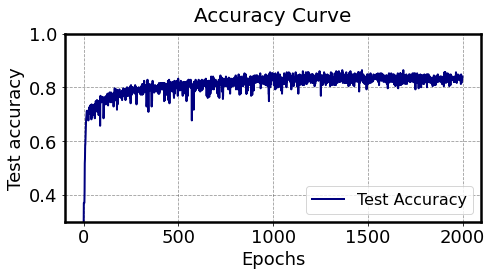

In [54]:
test_accuracy_plot(history_optimal_MFCCCNN_original, 2000, 'MFCC-CNN (original)', 
              yloss_limit1=0, yloss_limit2=12, yacc_limit1=0.3, yacc_limit2=1, interval=500)
save_fig("MFCC_CNN_Optimal_test_accuracy_original")

In [55]:
### X_test loss and accuracy score

xtest_loss_acc(model_optimal_MFCCCNN_original, X_test_original, y_test_original)

8/8 - 0s - loss: 0.4932 - accuracy: 0.8406
cnn loss: 0.49324
cnn accuracy: 0.84064


In [56]:
# %tensorboard --logdir logs/fit

### Prediction and Model Evaluation

In [57]:
yt_2,yp_2 = class_report(model_optimal_MFCCCNN_original, X_test_original, y_test_original, le)

               precision    recall  f1-score   support

       Cracks     0.7802    0.7978    0.7889        89
  Defect-free     0.8800    0.9462    0.9119        93
Keyhole pores     0.8667    0.7536    0.8062        69

     accuracy                         0.8406       251
    macro avg     0.8423    0.8325    0.8357       251
 weighted avg     0.8410    0.8406    0.8392       251



### Confusion matrix

[[71 11  7]
 [ 4 88  1]
 [16  1 52]]
Saving figure confusion_matrix_MFCC_CNN_optimal_original


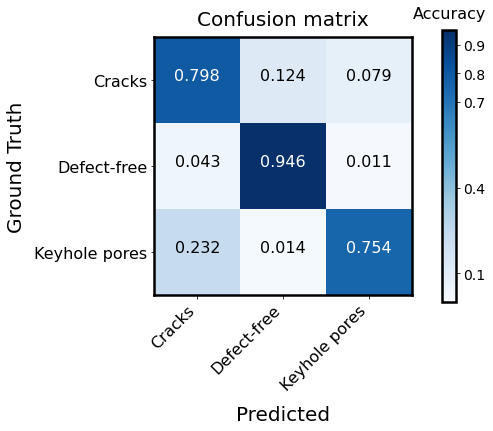

In [59]:
conf_matrix(yt_2, yp_2, le)
save_fig("confusion_matrix_MFCC_CNN_optimal_original")

In [38]:
classes_modified = np.array(['Defect-free', 'Cracks', 'Keyhole pores'])
classes_modified

array(['Defect-free', 'Cracks', 'Keyhole pores'], dtype='<U13')

Saving figure confusion_matrix_MFCC_CNN_optimal_original_corrected


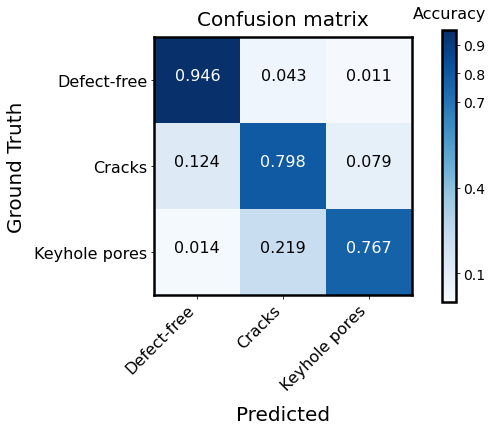

In [61]:
cm_modified = np.array([[88, 4,  1],[ 11, 71,  7], [1, 16, 56]])

# convert to percentage and plot the confusion matrix
cm_pct_original = cm_modified.astype(float) / cm_modified.sum(axis =1)[:,np.newaxis]
plot_confusion_matrix(cm_pct_original, classes_modified)
save_fig("confusion_matrix_MFCC_CNN_optimal_original_corrected")

In [59]:
# history_optimal_MFCCCNN_original

In [33]:
model_optimal_MFCCCNN_original.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 20, 87, 16)        416       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 10, 43, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 43, 16)        1040      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 21, 16)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 5, 21, 16)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 21, 32)         4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 2, 10, 32)        

# Denoised Dataset

In [64]:
### Load preprocess data and features from previous notebook

%store -r X_train_denoised 
%store -r X_test_denoised 
%store -r y_train_denoised
%store -r y_test_denoised 
%store -r le_denoised
%store -r class_weights_denoised

In [40]:
X_train_denoised.shape

(1000, 20, 87, 1)

In [38]:
input_shapes = (X_train_denoised.shape[1], X_train_denoised.shape[2], X_train_denoised.shape[3])
classes = le_denoised.classes_

### Hyperparameter tunining

In [53]:
### Set the hyperparameter for randomsearchCV

params = {
          'filter_one' : [16, 32], 'kernel_size_one' : [2,3,5],
          'filter_two' : [16,32,64], 'kernel_size_two' : [2,3,5], 'dropout_two': [0.2, 0.5],
          'filter_three' : [32, 64, 128], 'kernel_size_three' : [2,3,5], 'dropout_three': [0.2, 0.5],
          'neurons' : [64, 128, 256], 'dropout_four': [0.2, 0.5],
          'regularizer_rate' : [0.1, 0.05, 0.01],
          'opt_learning_rate' : [0.01, 0.001, 0.0001]
          # 'batch_size' = [20]
         }

# lambda_parameter = [0.01, 0.5, 1]
# epochs = [50, 100]
# batch_size = [20]
# param_grid = dict(lambda_parameter=lambda_parameter, epochs=epochs, 
# batch_size=batch_size)

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
# results_1 = grid_search.fit(X, y)

In [37]:
### Instantiate user defined function and run RandomizedSearchCV
input_shapes = (X_train_denoised.shape[1], X_train_denoised.shape[2], X_train_denoised.shape[3])

# nn = KerasClassifier(model = model_funcs, epochs = 100, 
#                     filter_one = 16, kernel_size_one = 2, input_shapes=input_shapes,
#                    filter_two = 16, kernel_size_two = 2, dropout_two = 0.2,
#                    filter_three = 32, kernel_size_three = 3, dropout_three = 0.2,
#                    neurons = 64, dropout_four = 0.5,
#                    regularizer_rate = 0.05,
#                    opt_learning_rate = 0.01)

nn = KerasClassifier(build_fn = model_funcs, epochs = 20)

### Instantiate RandomizedSearchCV
rscv = RandomizedSearchCV(nn, param_distributions = params, cv = 5)
# rscv = GridSearchCV(nn, param_grid = params, cv = 5)
rscv.fit(X_train_denoised, y_train_denoised)

# model best estimators
print(f"best estimator: {rscv.best_params_}")
print(f"best score: {rscv.best_score_}")

NameError: name 'params' is not defined

In [ ]:
### RandomizedSearchCV results

print(f" train score: {round(rscv.best_score_, 4)}")
print(f" test score: {round(rscv.score(X_test_denoised, y_test_denoised), 4)}")
print(f" best_parameters: {rscv.best_params_}")

### Hyperparameter tunining, method 2
- https://www.tensorflow.org/tutorials/keras/keras_tuner

In [70]:
!pip install -q -U keras-tuner

In [16]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [17]:
def model_builder(hp):
    '''
    tuned parameters:
    - learning rate: 0.01, 0.001, or 0.0001
    - regularizer_rate: min_value=0.01, max_value=0.15, step=0.05
    - filter, dropout rate
    
    '''
    
    model = keras.Sequential()
    # add 1st convolutional layer
    kernel_size_one = hp.Int('kernel_size_one', min_value=2, max_value=10, step=2)
    filter_one = hp.Choice('filter_one', values=[16, 32])
    model.add(Conv2D(filters = filter_one, kernel_size = kernel_size_one, activation = 'relu', padding = 'same',
                  input_shape = input_shapes))
    model.add(MaxPooling2D())
    
    # add 2nd convolutional layer
    kernel_size_two = kernel_size_two = hp.Int('units', min_value=2, max_value=10, step=2)
    filter_two = hp.Choice('filter_two', values=[16, 32, 64])
    dropout_two = hp.Choice('dropout_two', values=[0.2, 0.3, 0.5])
    model.add(Conv2D(filters = filter_two, kernel_size = kernel_size_two, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout_two))
    
    # add 3rd convolutional layer
    kernel_size_three = hp.Int('units', min_value=2, max_value=10, step=2)
    filter_three = hp.Choice('filter_three', values=[32, 64, 128])
    dropout_three = hp.Choice('dropout_three', values=[0.2, 0.3, 0.5])
    model.add(Conv2D(filters = filter_three, kernel_size = kernel_size_three, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout_three))
    
    # flatten layer before passing to FC layer
    model.add(Flatten())
    
    # add densely connected layer
    regularizer_rate =  hp.Float('units', min_value=0.01, max_value=0.15, step=0.03)
    neurons = hp.Choice('dropout_three', values=[64, 128, 256])
    model.add(Dense(neurons, activation = 'relu', kernel_regularizer = regularizers.l2(regularizer_rate)))
    model.add(BatchNormalization())
    
    dropout_four = hp.Choice('dropout_four', values=[0.2, 0.3, 0.5])
    model.add(Dropout(dropout_four))
    
    # add output layer
    model.add(Dense(len(classes), activation = 'softmax'))
    
    # add optimizer
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    Ad = optimizers.Adam(learning_rate = hp_learning_rate)
    
    # compile model
    model.compile(loss = 'categorical_crossentropy', optimizer= Ad, metrics = ['accuracy'])

    return model

In [18]:
# input_shapes = (X_train_denoised.shape[1], X_train_denoised.shape[2], X_train_denoised.shape[3])
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='Hp_tuning',
                     project_name='denoised_tuning')

In [19]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

In [ ]:
tuner.search(X_train_denoised, y_train_denoised, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

## CNN with Optimal Hyperparameter (denoised)
**X_train_denoised**

In [39]:
%time
### Fit model
### based on the previously determined value
# filter_one, kernel_size_one, input_shapes,
# filter_two, kernel_size_two, dropout_two,
# filter_three, kernel_size_three, dropout_three,
# neurons, dropout_four, regularizer_rate,
# opt_learning_rate
# model_optimal_MFCCCNN_denoised = model_funcs(16, 2,(X_train_denoised.shape[1], X_train_denoised.shape[2], X_train_denoised.shape[3]) ,
#                                              64, 3, 0.2,
#                                              64, 5, 0.5,
#                                              128, 0.5, 0.1,
#                                              0.001)

# model_optimal_MFCCCNN_denoised = model_funcs(32, 2,(X_train_denoised.shape[1], X_train_denoised.shape[2], X_train_denoised.shape[3]) ,
#                                              64, 2, 0.2,
#                                              128, 3, 0.5,
#                                              256, 0.5, 0.1,
#                                              0.0001)


lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                                        decay_steps=1000,
                                                        decay_rate=0.995)

# lr_schedule = keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.1,
#                                                         decay_steps =100000,
#                                                         end_learning_rate=0.00005,
#                                                         power=1.0,
#                                                         cycle=False,
#                                                         name=None,
#                                                         )

model_optimal_MFCCCNN_denoised = model_funcs(16, 5,(X_train_denoised.shape[1], X_train_denoised.shape[2], X_train_denoised.shape[3]) ,
                                            16, 2, 0.2,
                                             32, 3, 0.5,
                                             256, 0.2, 0.105,
                                             0.0001)

history_optimal_MFCCCNN_denoised = model_optimal_MFCCCNN_denoised.fit(X_train_denoised, y_train_denoised, 
                                                                      validation_data = (X_test_denoised, y_test_denoised), 
                                                                      epochs = 2500, shuffle = True, verbose =2) #class_weight=class_weights, batch_size = 16,

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
Epoch 1/2500
32/32 - 0s - loss: 38.6191 - accuracy: 0.3270 - val_loss: 36.4567 - val_accuracy: 0.3546
Epoch 2/2500
32/32 - 0s - loss: 35.6727 - accuracy: 0.3360 - val_loss: 33.6683 - val_accuracy: 0.3546
Epoch 3/2500
32/32 - 0s - loss: 32.9587 - accuracy: 0.3290 - val_loss: 31.1216 - val_accuracy: 0.3705
Epoch 4/2500
32/32 - 0s - loss: 30.4904 - accuracy: 0.3330 - val_loss: 28.7893 - val_accuracy: 0.3705
Epoch 5/2500
32/32 - 0s - loss: 28.1754 - accuracy: 0.3420 - val_loss: 26.6419 - val_accuracy: 0.3705
Epoch 6/2500
32/32 - 0s - loss: 26.0142 - accuracy: 0.3420 - val_loss: 24.6654 - val_accuracy: 0.3705
Epoch 7/2500
32/32 - 0s - loss: 24.1102 - accuracy: 0.3300 - val_loss: 22.8423 - val_accuracy: 0.3705
Epoch 8/2500
32/32 - 0s - loss: 22.2655 - accuracy: 0.3670 - val_loss: 21.1616 - val_accuracy: 0.3705
Epoch 9/2500
32/32 - 0s - loss: 20.6679 - accuracy: 0.3180 - val_loss: 19.6180 - val_accuracy: 0.3705
Epoch 10/2500
32/3

Saving figure MFCC_CNN_Optimal_training_denoised


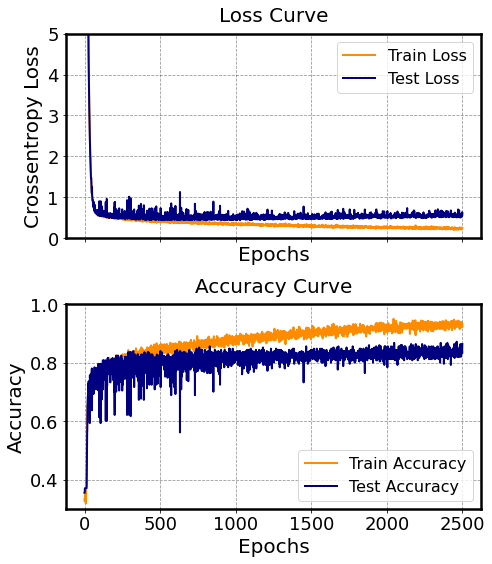

In [40]:
loss_acc_plot(history_optimal_MFCCCNN_denoised, 2500, 'MFCC-CNN (denoised)', 
              yloss_limit1=0, yloss_limit2=5, yacc_limit1=0.3, yacc_limit2=1, interval=500)
save_fig("MFCC_CNN_Optimal_training_denoised")

Saving figure MFCC_CNN_Optimal_test_accuracy_denoised


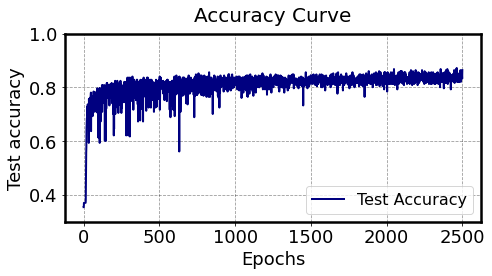

In [50]:
test_accuracy_plot(history_optimal_MFCCCNN_denoised, 2500, 'MFCC-CNN (denoised)', 
              yloss_limit1=0, yloss_limit2=12, yacc_limit1=0.3, yacc_limit2=1, interval=500)
save_fig("MFCC_CNN_Optimal_test_accuracy_denoised")

In [41]:
### X_test loss and accuracy score

xtest_loss_acc(model_optimal_MFCCCNN_denoised, X_test_denoised, y_test_denoised)

8/8 - 0s - loss: 0.5718 - accuracy: 0.8645
cnn loss: 0.57181
cnn accuracy: 0.86454


### Prediction and Model Evaluation


In [44]:
yt_denoised,yp_denoised = class_report(model_optimal_MFCCCNN_denoised, X_test_denoised, y_test_denoised, le_denoised)


               precision    recall  f1-score   support

       Cracks     0.8395    0.7640    0.8000        89
  Defect-free     0.9043    0.9140    0.9091        93
Keyhole pores     0.8421    0.9275    0.8828        69

     accuracy                         0.8645       251
    macro avg     0.8620    0.8685    0.8639       251
 weighted avg     0.8642    0.8645    0.8632       251



### Confusion matrix

[[68  9 12]
 [ 8 85  0]
 [ 5  0 64]]
Saving figure confusion_matrix_MFCC_CNN_optimal_denoised


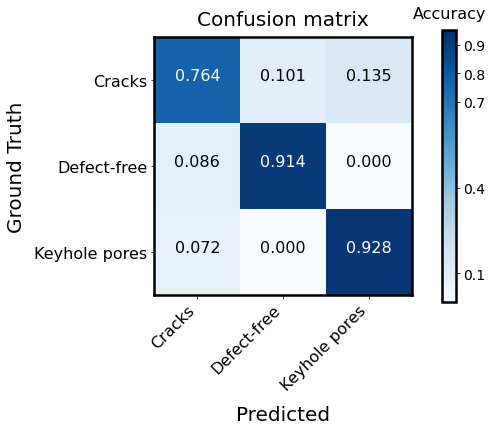

In [45]:
conf_matrix(yt_denoised, yp_denoised, le_denoised)
save_fig("confusion_matrix_MFCC_CNN_optimal_denoised")

Saving figure confusion_matrix_MFCC_CNN_optimal_denoised_corrected


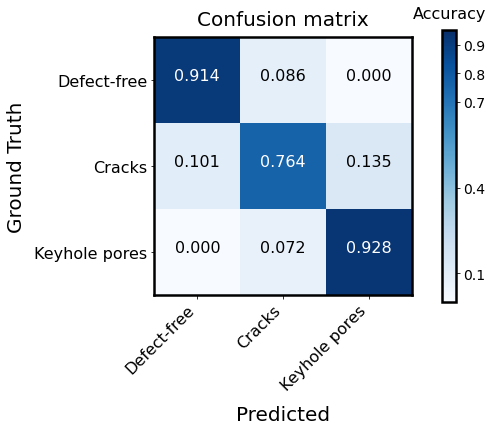

In [49]:
cm_modified = np.array([[85, 8,  0],[ 9, 68,  12], [0, 5, 64]])

# convert to percentage and plot the confusion matrix
cm_pct_denoised = cm_modified.astype(float) / cm_modified.sum(axis =1)[:,np.newaxis]
plot_confusion_matrix(cm_pct_denoised, classes_modified)
save_fig("confusion_matrix_MFCC_CNN_optimal_denoised_corrected")

In [78]:
classes_modified = np.array(['Defect-free','Cracks','Keyhole pores'])

In [74]:
classes

array(['Cracks', 'Defect-free', 'Keyhole pores'], dtype=object)

# Bandpassed Dataset

In [23]:
### Load preprocess data and features from previous notebook

%store -r X_train_bandpassed 
%store -r X_test_bandpassed 
%store -r y_train_bandpassed
%store -r y_test_bandpassed 
%store -r le_bandpassed
%store -r class_weights_bandpassed

In [24]:
input_shapes = (X_train_bandpassed.shape[1], X_train_bandpassed.shape[2], X_train_bandpassed.shape[3])
classes = le_bandpassed.classes_

### Hyperparameter tunining

In [72]:
### Set the hyperparameter for randomsearchCV

params = {
          'filter_one' : [16, 32], 'kernel_size_one' : [2,3,5],
          'filter_two' : [16,32,64], 'kernel_size_two' : [2,3,5], 'dropout_two': [0.2, 0.5],
          'filter_three' : [32, 64, 128], 'kernel_size_three' : [2,3,5], 'dropout_three': [0.2, 0.5],
          'neurons' : [64, 128, 256], 'dropout_four': [0.2, 0.5],
          'regularizer_rate' : [0.1, 0.05, 0.01],
          'opt_learning_rate' : [0.01, 0.001, 0.0001]
          # 'batch_size' = [20]
         }

# lambda_parameter = [0.01, 0.5, 1]
# epochs = [50, 100]
# batch_size = [20]
# param_grid = dict(lambda_parameter=lambda_parameter, epochs=epochs, 
# batch_size=batch_size)

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
# results_1 = grid_search.fit(X, y)

In [83]:
### Instantiate user defined function and run RandomizedSearchCV
input_shapes = (X_train_bandpassed.shape[1], X_train_bandpassed.shape[2], X_train_bandpassed.shape[3])

nn = KerasClassifier(model = model_funcs, epochs = 50, 
                    filter_one = 16, kernel_size_one = 2, input_shapes=input_shapes,
                   filter_two = 16, kernel_size_two = 2, dropout_two = 0.2,
                   filter_three = 32, kernel_size_three = 3, dropout_three = 0.2,
                   neurons = 64, dropout_four = 0.5,
                   regularizer_rate = 0.05,
                   opt_learning_rate = 0.01)

### Instantiate RandomizedSearchCV
rscv = RandomizedSearchCV(nn, param_distributions = params, cv = 5)
# rscv = GridSearchCV(nn, param_grid = params, cv = 5)
rscv.fit(X_train_bandpassed, y_train_bandpassed)

# model best estimators
print(f"best estimator: {rscv.best_params_}")
print(f"best score: {rscv.best_score_}")

Epoch 1/50
25/25 [==============================] - 1s 11ms/step - loss: 10.1803 - accuracy: 0.3313
Epoch 2/50
25/25 [==============================] - 0s 11ms/step - loss: 3.8605 - accuracy: 0.3600
Epoch 3/50
25/25 [==============================] - 0s 11ms/step - loss: 2.9307 - accuracy: 0.3688
Epoch 4/50
25/25 [==============================] - 0s 11ms/step - loss: 2.8710 - accuracy: 0.3388
Epoch 5/50
25/25 [==============================] - 0s 11ms/step - loss: 2.8416 - accuracy: 0.3500
Epoch 6/50
25/25 [==============================] - 0s 11ms/step - loss: 2.8070 - accuracy: 0.3400
Epoch 7/50
25/25 [==============================] - 0s 12ms/step - loss: 2.3195 - accuracy: 0.3800
Epoch 8/50
25/25 [==============================] - 0s 11ms/step - loss: 2.3009 - accuracy: 0.3487
Epoch 9/50
25/25 [==============================] - 0s 11ms/step - loss: 2.2126 - accuracy: 0.3462
Epoch 10/50
25/25 [==============================] - 0s 11ms/step - loss: 1.8985 - accuracy: 0.3688
Epoch 11

In [84]:
### RandomizedSearchCV results

print(f" train score: {round(rscv.best_score_, 4)}")
print(f" test score: {round(rscv.score(X_test_bandpassed, y_test_bandpassed), 4)}")
print(f" best_parameters: {rscv.best_params_}")

 train score: 0.762
8/8 [==============================] - 0s 6ms/step
 test score: 0.7649
 best_parameters: {'regularizer_rate': 0.05, 'opt_learning_rate': 0.0001, 'neurons': 64, 'kernel_size_two': 2, 'kernel_size_three': 5, 'kernel_size_one': 2, 'filter_two': 32, 'filter_three': 128, 'filter_one': 16, 'dropout_two': 0.2, 'dropout_three': 0.5, 'dropout_four': 0.2}


## CNN with Optimal Hyperparameter (bandpassed)
**X_train_bandpassed**

In [28]:
### Fit model
### based on the previously determined value
# filter_one, kernel_size_one, input_shapes,
# filter_two, kernel_size_two, dropout_two,
# filter_three, kernel_size_three, dropout_three,
# neurons, dropout_four, regularizer_rate,
# opt_learning_rate
# model_optimal_MFCCCNN_bandpassed = model_funcs(16, 2,(X_train_bandpassed.shape[1], X_train_bandpassed.shape[2], X_train_bandpassed.shape[3]) ,
#                                              32, 2, 0.2,
#                                              128, 5, 0.5,
#                                              64, 0.2, 0.12,
#                                              0.0001)
model_optimal_MFCCCNN_bandpassed = model_funcs(16, 5,(X_train_bandpassed.shape[1], X_train_bandpassed.shape[2], X_train_bandpassed.shape[3]) ,
                                             16, 2, 0.2,
                                             32, 3, 0.5,
                                             256, 0.2, 0.1,
                                             0.0001)
    



callback = EarlyStopping(monitor='val_accuracy', patience=500, restore_best_weights=True)
    
history_optimal_MFCCCNN_bandpassed = model_optimal_MFCCCNN_bandpassed.fit(X_train_bandpassed, y_train_bandpassed, 
                                                                      validation_data = (X_test_bandpassed, y_test_bandpassed),
                                                                      epochs = 2000, shuffle = True, verbose =2) #class_weight=class_weights, callbacks=[callback]

Epoch 1/2000
32/32 - 0s - loss: 36.8713 - accuracy: 0.3270 - val_loss: 34.8708 - val_accuracy: 0.2749
Epoch 2/2000
32/32 - 0s - loss: 34.0960 - accuracy: 0.3180 - val_loss: 32.2467 - val_accuracy: 0.3586
Epoch 3/2000
32/32 - 0s - loss: 31.4585 - accuracy: 0.3750 - val_loss: 29.8305 - val_accuracy: 0.3625
Epoch 4/2000
32/32 - 0s - loss: 29.1495 - accuracy: 0.3480 - val_loss: 27.5965 - val_accuracy: 0.3705
Epoch 5/2000
32/32 - 0s - loss: 26.9374 - accuracy: 0.3500 - val_loss: 25.5392 - val_accuracy: 0.3705
Epoch 6/2000
32/32 - 0s - loss: 24.9293 - accuracy: 0.3580 - val_loss: 23.6374 - val_accuracy: 0.3705
Epoch 7/2000
32/32 - 0s - loss: 23.0238 - accuracy: 0.3560 - val_loss: 21.8847 - val_accuracy: 0.3705
Epoch 8/2000
32/32 - 0s - loss: 21.3075 - accuracy: 0.3380 - val_loss: 20.2603 - val_accuracy: 0.3705
Epoch 9/2000
32/32 - 0s - loss: 19.7129 - accuracy: 0.3600 - val_loss: 18.7606 - val_accuracy: 0.3705
Epoch 10/2000
32/32 - 0s - loss: 18.1936 - accuracy: 0.3560 - val_loss: 17.3715 - 

Saving figure MFCC_CNN_Optimal_training_bandpassed


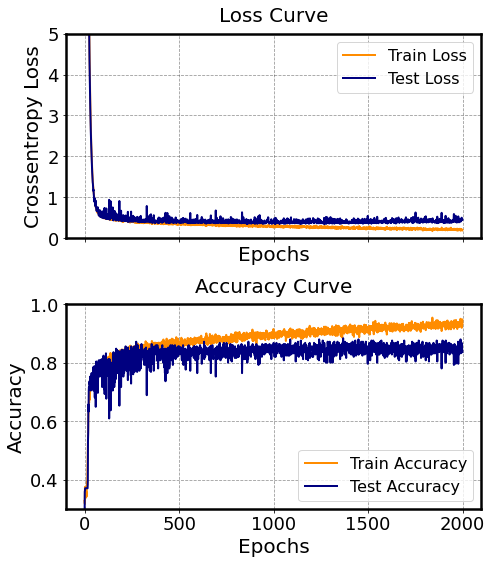

In [29]:
loss_acc_plot(history_optimal_MFCCCNN_bandpassed, 2000, 'MFCC-CNN (bandpassed)', 
              yloss_limit1=0, yloss_limit2=5, yacc_limit1=0.3, yacc_limit2=1, interval=500)
save_fig("MFCC_CNN_Optimal_training_bandpassed")

Saving figure MFCC_CNN_Optimal_test_bandpassed


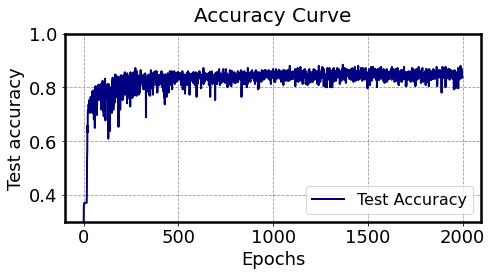

In [32]:
test_accuracy_plot(history_optimal_MFCCCNN_bandpassed, 2000, 'MFCC-CNN (test)', 
              yloss_limit1=0, yloss_limit2=12, yacc_limit1=0.3, yacc_limit2=1, interval=500)
save_fig("MFCC_CNN_Optimal_test_bandpassed")

In [33]:
### X_test loss and accuracy score

xtest_loss_acc(model_optimal_MFCCCNN_bandpassed, X_test_bandpassed, y_test_bandpassed)

8/8 - 0s - loss: 0.4494 - accuracy: 0.8367
cnn loss: 0.44942
cnn accuracy: 0.83665


### Prediction and Model Evaluation

In general, imbalanced dataset without treatment does not perform good, particularly not able to classify the minority class well.

In [34]:
yt_bandpassed,yp_bandpassed = class_report(model_optimal_MFCCCNN_bandpassed, X_test_bandpassed, y_test_bandpassed, le_bandpassed)

               precision    recall  f1-score   support

       Cracks     0.7667    0.7753    0.7709        89
  Defect-free     0.8529    0.9355    0.8923        93
Keyhole pores     0.9153    0.7826    0.8437        69

     accuracy                         0.8367       251
    macro avg     0.8450    0.8311    0.8357       251
 weighted avg     0.8395    0.8367    0.8359       251



### Confusion matrix

[[69 15  5]
 [ 6 87  0]
 [15  0 54]]
Saving figure confusion_matrix_MFCC_CNN_optimal_bandpassed


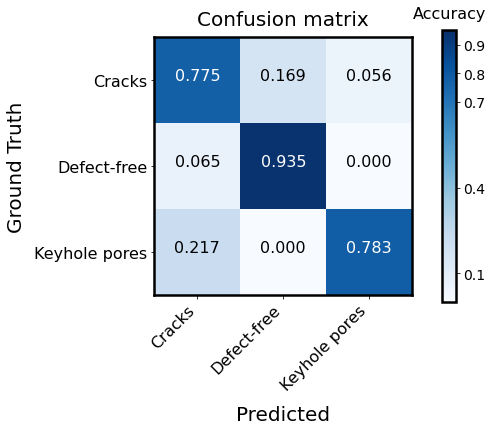

In [35]:
conf_matrix(yt_bandpassed, yp_bandpassed, le_bandpassed)
save_fig("confusion_matrix_MFCC_CNN_optimal_bandpassed")

Saving figure confusion_matrix_MFCC_CNN_optimal_bandpassed_corrected


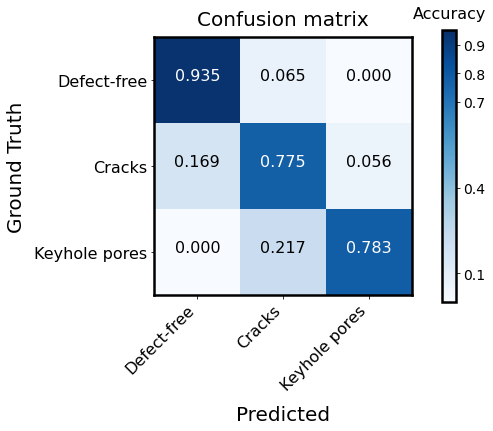

In [39]:
cm_modified = np.array([[87, 6,  0],[ 15, 69,  5], [0, 15, 54]])

# convert to percentage and plot the confusion matrix
cm_pct_bandpassed = cm_modified.astype(float) / cm_modified.sum(axis =1)[:,np.newaxis]
plot_confusion_matrix(cm_pct_bandpassed, classes_modified)
save_fig("confusion_matrix_MFCC_CNN_optimal_bandpassed_corrected")

# Equalized Dataset

In [40]:
### Load preprocess data and features from previous notebook

%store -r X_train_equalized 
%store -r X_test_equalized  
%store -r y_train_equalized 
%store -r y_test_equalized  
%store -r le_equalized 
%store -r class_weights_equalized 

In [41]:
input_shapes = (X_train_equalized.shape[1], X_train_equalized.shape[2], X_train_equalized.shape[3])
classes = le_equalized.classes_

### Hyperparameter tunining

In [43]:
### Set the hyperparameter for randomsearchCV

params = {
          'filter_one' : [16, 32], 'kernel_size_one' : [2,3,5],
          'filter_two' : [16,32,64], 'kernel_size_two' : [2,3,5], 'dropout_two': [0.2, 0.5],
          'filter_three' : [32, 64, 128], 'kernel_size_three' : [2,3,5], 'dropout_three': [0.2, 0.5],
          'neurons' : [64, 128, 256], 'dropout_four': [0.2, 0.5],
          'regularizer_rate' : [0.1, 0.05, 0.01],
          'opt_learning_rate' : [0.01, 0.001, 0.0001]
          # 'batch_size' = [20]
         }

# lambda_parameter = [0.01, 0.5, 1]
# epochs = [50, 100]
# batch_size = [20]
# param_grid = dict(lambda_parameter=lambda_parameter, epochs=epochs, 
# batch_size=batch_size)

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
# results_1 = grid_search.fit(X, y)

In [44]:
### Instantiate user defined function and run RandomizedSearchCV
input_shapes = (X_train_equalized.shape[1], X_train_equalized.shape[2], X_train_equalized.shape[3])

nn = KerasClassifier(model = model_funcs, epochs = 50, 
                    filter_one = 16, kernel_size_one = 2, input_shapes=input_shapes,
                   filter_two = 16, kernel_size_two = 2, dropout_two = 0.2,
                   filter_three = 32, kernel_size_three = 3, dropout_three = 0.2,
                   neurons = 64, dropout_four = 0.5,
                   regularizer_rate = 0.05,
                   opt_learning_rate = 0.01)

### Instantiate RandomizedSearchCV
rscv = RandomizedSearchCV(nn, param_distributions = params, cv = 5)
# rscv = GridSearchCV(nn, param_grid = params, cv = 5)
rscv.fit(X_train_equalized, y_train_equalized)

# model best estimators
print(f"best estimator: {rscv.best_params_}")
print(f"best score: {rscv.best_score_}")

AttributeError: 'KerasClassifier' object has no attribute '__call__'

In [109]:
### RandomizedSearchCV results

print(f" train score: {round(rscv.best_score_, 4)}")
print(f" test score: {round(rscv.score(X_test_equalized, y_test_equalized), 4)}")
print(f" best_parameters: {rscv.best_params_}")

 train score: 0.747
8/8 [==============================] - 0s 5ms/step
 test score: 0.749
 best_parameters: {'regularizer_rate': 0.1, 'opt_learning_rate': 0.0001, 'neurons': 256, 'kernel_size_two': 2, 'kernel_size_three': 3, 'kernel_size_one': 5, 'filter_two': 16, 'filter_three': 32, 'filter_one': 16, 'dropout_two': 0.2, 'dropout_three': 0.5, 'dropout_four': 0.2}


## CNN with Optimal Hyperparameter (equalized)
**X_train_equalized**

In [42]:
### Fit model
### based on the previously determined value
# filter_one, kernel_size_one, input_shapes,
# filter_two, kernel_size_two, dropout_two,
# filter_three, kernel_size_three, dropout_three,
# neurons, dropout_four, regularizer_rate,
# opt_learning_rate
model_optimal_MFCCCNN_equalized = model_funcs(16, 5,(X_train_equalized.shape[1], X_train_equalized.shape[2], X_train_equalized.shape[3]) ,
                                             16, 2, 0.2,
                                             32, 3, 0.5,
                                             256, 0.2, 0.1,
                                             0.0001)
    
history_optimal_MFCCCNN_equalized = model_optimal_MFCCCNN_equalized.fit(X_train_equalized, y_train_equalized, 
                                                                      validation_data = (X_test_equalized, y_test_equalized),
                                                                      epochs = 2500, shuffle = True, verbose =2) #class_weight=class_weights

Epoch 1/2500
32/32 - 0s - loss: 36.8432 - accuracy: 0.3250 - val_loss: 34.8340 - val_accuracy: 0.2669
Epoch 2/2500
32/32 - 0s - loss: 34.0336 - accuracy: 0.3380 - val_loss: 32.1574 - val_accuracy: 0.2789
Epoch 3/2500
32/32 - 0s - loss: 31.4184 - accuracy: 0.3210 - val_loss: 29.7057 - val_accuracy: 0.3785
Epoch 4/2500
32/32 - 0s - loss: 28.9533 - accuracy: 0.3430 - val_loss: 27.4497 - val_accuracy: 0.3546
Epoch 5/2500
32/32 - 0s - loss: 26.7964 - accuracy: 0.3290 - val_loss: 25.3649 - val_accuracy: 0.3546
Epoch 6/2500
32/32 - 0s - loss: 24.6621 - accuracy: 0.3680 - val_loss: 23.4371 - val_accuracy: 0.3546
Epoch 7/2500
32/32 - 0s - loss: 22.8248 - accuracy: 0.3470 - val_loss: 21.6549 - val_accuracy: 0.3546
Epoch 8/2500
32/32 - 0s - loss: 21.0720 - accuracy: 0.3450 - val_loss: 20.0066 - val_accuracy: 0.3546
Epoch 9/2500
32/32 - 0s - loss: 19.4061 - accuracy: 0.3490 - val_loss: 18.4819 - val_accuracy: 0.3865
Epoch 10/2500
32/32 - 0s - loss: 17.9046 - accuracy: 0.3550 - val_loss: 17.0675 - 

Saving figure MFCC_CNN_Optimal_training_equalized


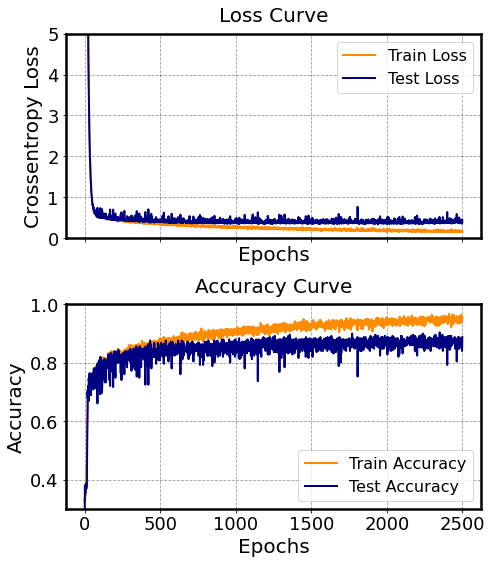

In [43]:
loss_acc_plot(history_optimal_MFCCCNN_equalized, 2500, 'MFCC-CNN (equalized)', 
              yloss_limit1=0, yloss_limit2=5, yacc_limit1=0.3, yacc_limit2=1, interval=500)
save_fig("MFCC_CNN_Optimal_training_equalized")

Saving figure MFCC_CNN_Optimal_test_accuracy_equalized


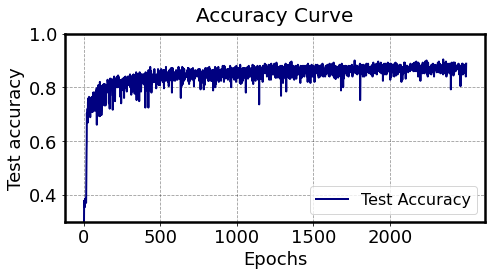

In [44]:
test_accuracy_plot(history_optimal_MFCCCNN_equalized, 2000, 'MFCC-CNN (equalized)', 
              yloss_limit1=0, yloss_limit2=12, yacc_limit1=0.3, yacc_limit2=1, interval=500)
save_fig("MFCC_CNN_Optimal_test_accuracy_equalized")

In [45]:
### X_test loss and accuracy score

xtest_loss_acc(model_optimal_MFCCCNN_equalized, X_test_equalized, y_test_equalized)

8/8 - 0s - loss: 0.3875 - accuracy: 0.8884
cnn loss: 0.38747
cnn accuracy: 0.88845


### Prediction and Model Evaluation

Model with optimized hyperparameter resulted in:

In general, imbalanced dataset without treatment does not perform good, particularly not able to classify the minority class well.

In [46]:
yt_equalized, yp_equalized = class_report(model_optimal_MFCCCNN_equalized, X_test_equalized, y_test_equalized, le_equalized)

               precision    recall  f1-score   support

       Cracks     0.8144    0.8876    0.8495        89
  Defect-free     0.9239    0.9140    0.9189        93
Keyhole pores     0.9516    0.8551    0.9008        69

     accuracy                         0.8884       251
    macro avg     0.8967    0.8856    0.8897       251
 weighted avg     0.8927    0.8884    0.8893       251



### Confusion matrix

[[79  7  3]
 [ 8 85  0]
 [10  0 59]]
Saving figure confusion_matrix_MFCC_CNN_optimal_equalized


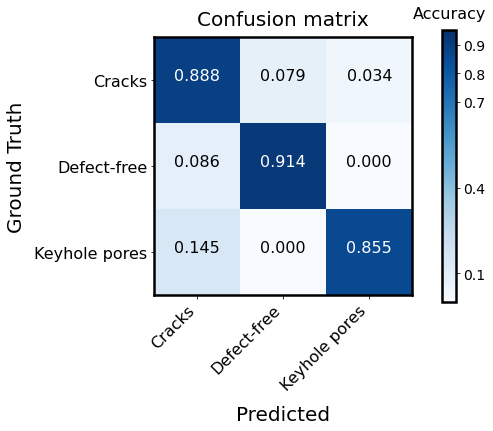

In [47]:
conf_matrix(yt_equalized, yp_equalized, le_equalized)
save_fig("confusion_matrix_MFCC_CNN_optimal_equalized")

Saving figure confusion_matrix_MFCC_CNN_optimal_equalized_corrected


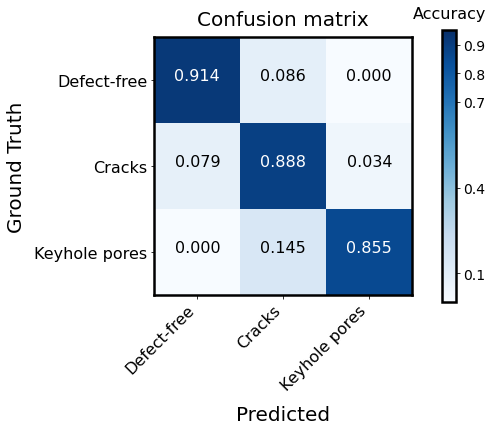

In [48]:
cm_modified = np.array([[85, 8,  0],[7, 79, 3], [0, 10, 59]])

# convert to percentage and plot the confusion matrix
cm_pct_equalized = cm_modified.astype(float) / cm_modified.sum(axis =1)[:,np.newaxis]
plot_confusion_matrix(cm_pct_equalized, classes_modified)
save_fig("confusion_matrix_MFCC_CNN_optimal_equalized_corrected")

# Performance evaluation - Summary

In [62]:
X_original = np.concatenate((X_test_original,X_train_original))
y_original = np.concatenate((y_test_original,y_train_original))

X_original.shape

(1251, 20, 87, 1)

In [63]:
# seed = 7
# np.random.seed(seed)
# kfold = StratifiedKFold(n_splits=5)
# for train, test in kfold.split(X_test_original):
#     print (test)

kf = KFold(n_splits=10, shuffle = True, random_state=0)
for train_index, test_index in kf.split(X_test_original):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_test_original[train_index], X_test_original[test_index]
    y_train, y_test = y_test_original[train_index], y_test_original[test_index]
    

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72  74
  75  76  77  78  79  80  81  82  84  85  86  87  88  89  91  93  94  95
  97  98  99 100 101 102 103 104 105 106 107 109 110 112 113 114 115 117
 118 119 120 121 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 145 146 147 148 150 151 154 156 159 160 161
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 179 180 181
 182 183 184 185 186 188 189 190 191 192 193 194 195 196 197 198 200 201
 202 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 232 233 234 235 236 237 239 240 241
 242 243 244 245 246 247 248 249 250] TEST: [ 45  63  73  83  90  92  96 108 111 116 122 144 149 152 153 155 157 158


In [247]:
type(X_test_original)

numpy.ndarray

In [311]:
X_test_original.shape

(251, 20, 87, 1)

In [50]:
# y_score = model_optimal_MFCCCNN_original.predict_classes(type(X_test_original))

y_score = (model_optimal_MFCCCNN_original.predict(X_test_original) > 0.5).astype("int32")
# print (y_score)

In [53]:
def model_evaluation(model, X, Y, classes, classifier_name = "MFCC-CNN", signal_type = "denoised"):
    n_classes = len(classes)
    #################--------------------------------------------------------------------#####################
    ################------------- Perform cross-validation on the model ------- ---------#####################
    ################---------------------------------------------------------------------#####################
    kf = KFold(n_splits=5, shuffle = True, random_state=0)
    trains = []
    tests = []
    # fix random seed for reproducibility
    # seed = 7
    # np.random.seed(seed)
    # kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    # for train, test in kfold.split(X, Y):
    for train_index, test_index in kf.split(X):

#         X_shuffle, y_shuffle = shuffle(X, Y, random_state=0)
#         y_shuffle = np.array(y_shuffle)

#         X_train_cv = X_shuffle[train_index]
#         X_test_cv = X_shuffle[test_index]
#         y_train_cv = y_shuffle[train_index]
#         y_test_cv = y_shuffle[test_index]

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        scores = model.evaluate(X_test, y_test, verbose =2)
        # scores[0] is loss, scores[1] is accuracy 
        tests.append(scores[1])

    # tests = np.array(tests)
    # test_accuracy_mean = tests.mean()
    # test_accuracy_std = tests.std()
    test_accuracy_mean = np.mean(tests)
    test_accuracy_std =  np.std(tests)

#     #################--------------------------------------------------------------------#####################
#     ################---------------------- AUC-ROC score measurement --------------------#####################
#     ################---------------------------------------------------------------------#####################
    

#     # ----------------Learn to predict each class against the other------------------------
#     # classifier = OneVsRestClassifier(model)
#     # # if classifier_name == 'SVC':
#     # #     y_score = classifier.fit(X_train, y_train).decision_function(X_test)
#     # # else:
    # y_score = classifier.fit(X_train, Y_train_ohe).predict_proba(X_test)
    y_score = model.predict(X)
    
#     y_score = model.evaluate(X_test, y_test, verbose =2)
    # ---------------Compute ROC curve and ROC area for each class-------------------------
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # ----------------------------------Plot all ROC curves-------------------------------
    plt.figure(figsize = (4,3), dpi = 300)
    widths = 2
    ax = gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(widths)

        tick_width = 1.5
    plt.tick_params(direction = 'in', width = tick_width)
    
    #---------------------------(1) micro and macro ROC curve---------------------------
    plt.plot(fpr["micro"], tpr["micro"],
             label=classifier_name + ' - micro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=2, alpha = 0.8) #deeppink, midnightblue

    plt.plot(fpr["macro"], tpr["macro"],
             label=classifier_name + ' - macro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=2, alpha = 0.8) #navy, gold
    
    #---------------------------(2) ROC curve for each class---------------------------
    colors = cycle(["darkblue", "aqua","darkorange", "red"])
    # colors = cycle(['0.45', 'steelblue',  'olive', 'silver'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i],tpr[i],color=color,
                 lw=1, alpha = 0.8,
                 label=classifier_name + " ROC curve of class \"{0}\" (area = {1:0.2f})".format(classes[i], roc_auc[i])) 

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # plt.title("ROC curve")
    plt.legend(loc="lower right",  fontsize = '5', frameon = False)
    # plt.show()
    
    #----------------------------------Extract the auc score to list-----------------------------------
    auc_score_list = []
    auc_score_list.append(auc(fpr["micro"], tpr["micro"]))
    
    auc_score_array = np.array(auc_score_list)
    auc_mean = auc_score_array.mean()
    auc_std = auc_score_array.std()
    
    
    #################--------------------------------------------------------------------#####################
    ################------------------------------- Summary -----------------------------#####################
    ################---------------------------------------------------------------------#####################
    
    
    print('Test Accuracy (cross-validation) for' , classifier_name, '= {:.5f} ± {:.5f}'.format(test_accuracy_mean, test_accuracy_std))
    print('micro-averaging AUC for' , classifier_name, '= {:.5f} ± {:.5f}'.format(auc_mean, auc_std))
    save_fig("ROC_" + classifier_name + "_" + signal_type)
    
    return test_accuracy_mean, test_accuracy_std, auc_mean, auc_std

In [65]:
classes

array(['Cracks', 'Defect-free', 'Keyhole pores'], dtype=object)

In [52]:
print (y_test_original.shape)
print (X_test_original.shape)

(251, 3)
(251, 20, 87, 1)


In [55]:
# save model
filename = 'models/model_' + "model_optimal_MFCCCNN_original" + '.h5'
model_optimal_MFCCCNN_original.save(filename)
print('>Saved %s' % filename)

filename = 'models/model_' + "model_optimal_MFCCCNN_equalized" + '.h5'
model_optimal_MFCCCNN_equalized.save(filename)
print('>Saved %s' % filename)

filename = 'models/model_' + "model_optimal_MFCCCNN_bandpassed" + '.h5'
model_optimal_MFCCCNN_bandpassed.save(filename)
print('>Saved %s' % filename)

filename = 'models/model_' + "model_optimal_MFCCCNN_denoised" + '.h5'
model_optimal_MFCCCNN_denoised.save(filename)
print('>Saved %s' % filename)

>Saved models/model_model_optimal_MFCCCNN_equalized.h5
>Saved models/model_model_optimal_MFCCCNN_bandpassed.h5


In [57]:
model_optimal_MFCCCNN_original = keras.models.load_model('models/model_model_optimal_MFCCCNN_original.h5')
model_optimal_MFCCCNN_equalized = keras.models.load_model('models/model_model_optimal_MFCCCNN_equalized.h5')
model_optimal_MFCCCNN_bandpassed = keras.models.load_model('models/model_model_optimal_MFCCCNN_bandpassed.h5')
model_optimal_MFCCCNN_denoised = keras.models.load_model('models/model_model_optimal_MFCCCNN_denoised.h5')

2/2 - 0s - loss: 0.3492 - accuracy: 0.8824
2/2 - 0s - loss: 0.8033 - accuracy: 0.7800
2/2 - 0s - loss: 0.2246 - accuracy: 0.9000
2/2 - 0s - loss: 0.5666 - accuracy: 0.8000
2/2 - 0s - loss: 0.5253 - accuracy: 0.8400
Test Accuracy (cross-validation) for MFCC-CNN = 0.84047 ± 0.04603
micro-averaging AUC for MFCC-CNN = 0.95325 ± 0.00000
Saving figure ROC_MFCC-CNN_original


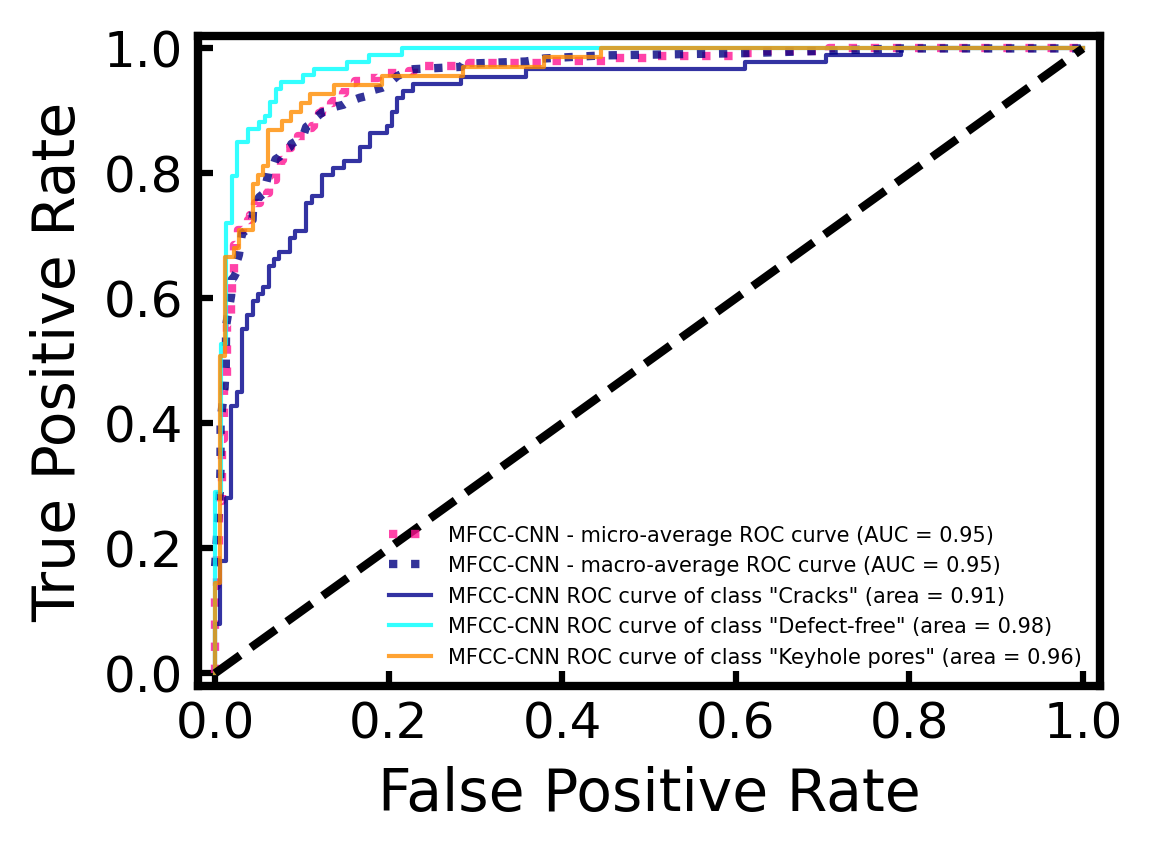

In [59]:
cnn_original_test_accuracy_mean, cnn_original_test_accuracy_std, cnn_original_auc_mean, cnn_original_auc_std= model_evaluation(model_optimal_MFCCCNN_original, 
                                                               X_test_original, y_test_original, 
                                                               classes=le.classes_, classifier_name = "MFCC-CNN", 
                                                               signal_type = "original")

2/2 - 0s - loss: 0.3478 - accuracy: 0.9020
2/2 - 0s - loss: 0.5930 - accuracy: 0.8200
2/2 - 0s - loss: 0.3091 - accuracy: 0.9000
2/2 - 0s - loss: 0.2867 - accuracy: 0.9600
2/2 - 0s - loss: 0.4016 - accuracy: 0.8600
Test Accuracy (cross-validation) for MFCC-CNN = 0.88839 ± 0.04675
micro-averaging AUC for MFCC-CNN = 0.97034 ± 0.00000
Saving figure ROC_MFCC-CNN_equalized


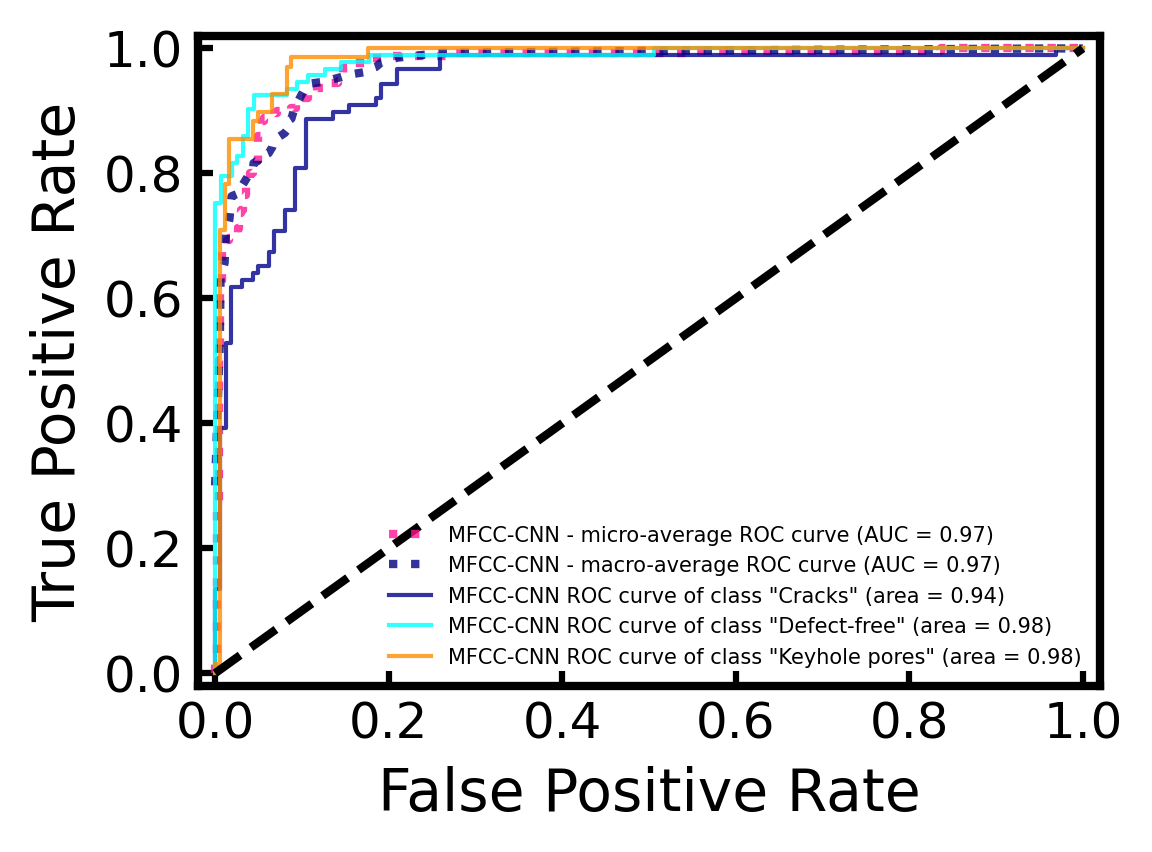

In [60]:
cnn_equalized_test_accuracy_mean, cnn_equalized_test_accuracy_std, cnn_equalized_auc_mean, cnn_equalized_auc_std= model_evaluation(model_optimal_MFCCCNN_equalized, 
                                                                                                               X_test_equalized, y_test_equalized, 
                                                                                                               classes=le.classes_, classifier_name = "MFCC-CNN", 
                                                                                                               signal_type = "equalized")

2/2 - 0s - loss: 0.4501 - accuracy: 0.8824
2/2 - 0s - loss: 0.5734 - accuracy: 0.8000
2/2 - 0s - loss: 0.3676 - accuracy: 0.8400
2/2 - 0s - loss: 0.3742 - accuracy: 0.8200
2/2 - 0s - loss: 0.4818 - accuracy: 0.8400
Test Accuracy (cross-validation) for MFCC-CNN = 0.83647 ± 0.02732
micro-averaging AUC for MFCC-CNN = 0.96537 ± 0.00000
Saving figure ROC_MFCC-CNN_bandpassed


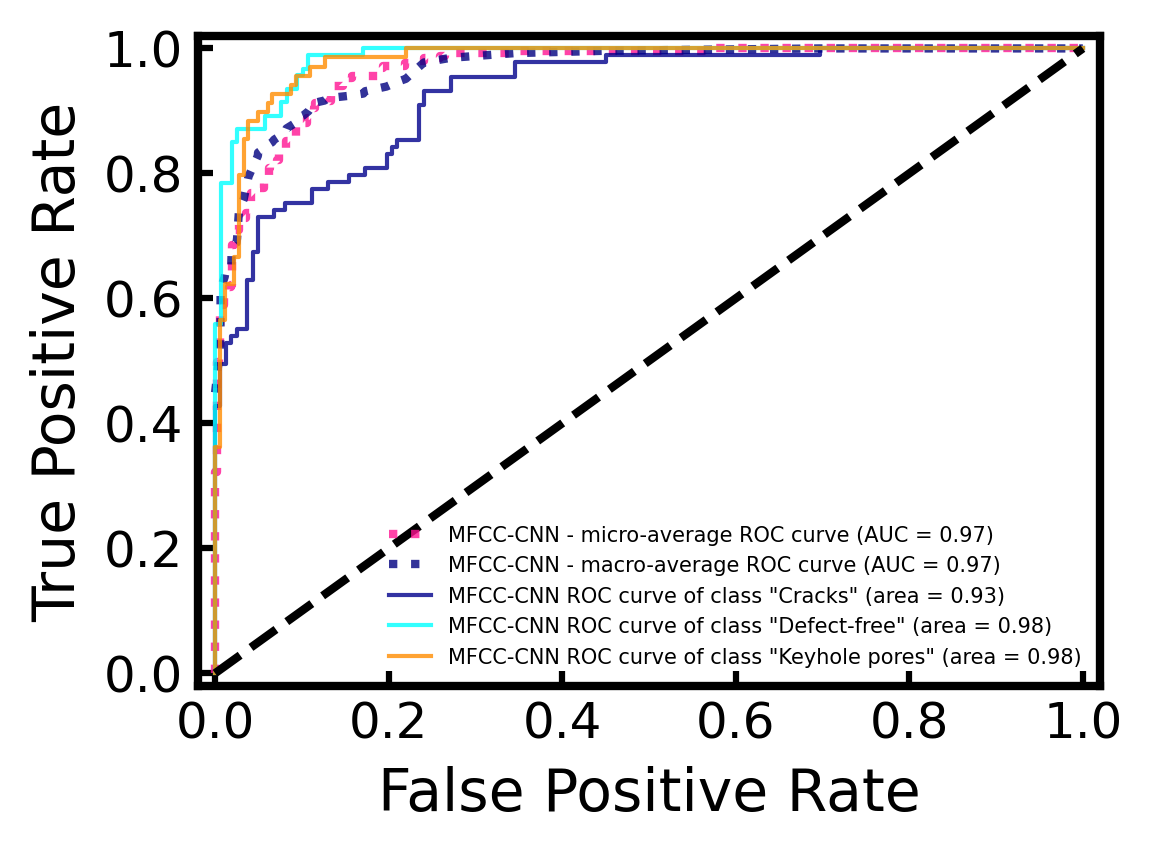

In [61]:
cnn_bandpassed_test_accuracy_mean, cnn_bandpassed_test_accuracy_std, cnn_bandpassed_auc_mean, cnn_bandpassed_auc_std= model_evaluation(model_optimal_MFCCCNN_bandpassed, 
                                                                                                               X_test_bandpassed, y_test_bandpassed, 
                                                                                                               classes=le.classes_, classifier_name = "MFCC-CNN", 
                                                                                                               signal_type = "bandpassed")

2/2 - 0s - loss: 0.6265 - accuracy: 0.8235
2/2 - 0s - loss: 0.6380 - accuracy: 0.8200
2/2 - 0s - loss: 0.6105 - accuracy: 0.8600
2/2 - 0s - loss: 0.7677 - accuracy: 0.8600
2/2 - 0s - loss: 0.2153 - accuracy: 0.9600
Test Accuracy (cross-validation) for MFCC-CNN = 0.86471 ± 0.05063
micro-averaging AUC for MFCC-CNN = 0.94634 ± 0.00000
Saving figure ROC_MFCC-CNN_denoised


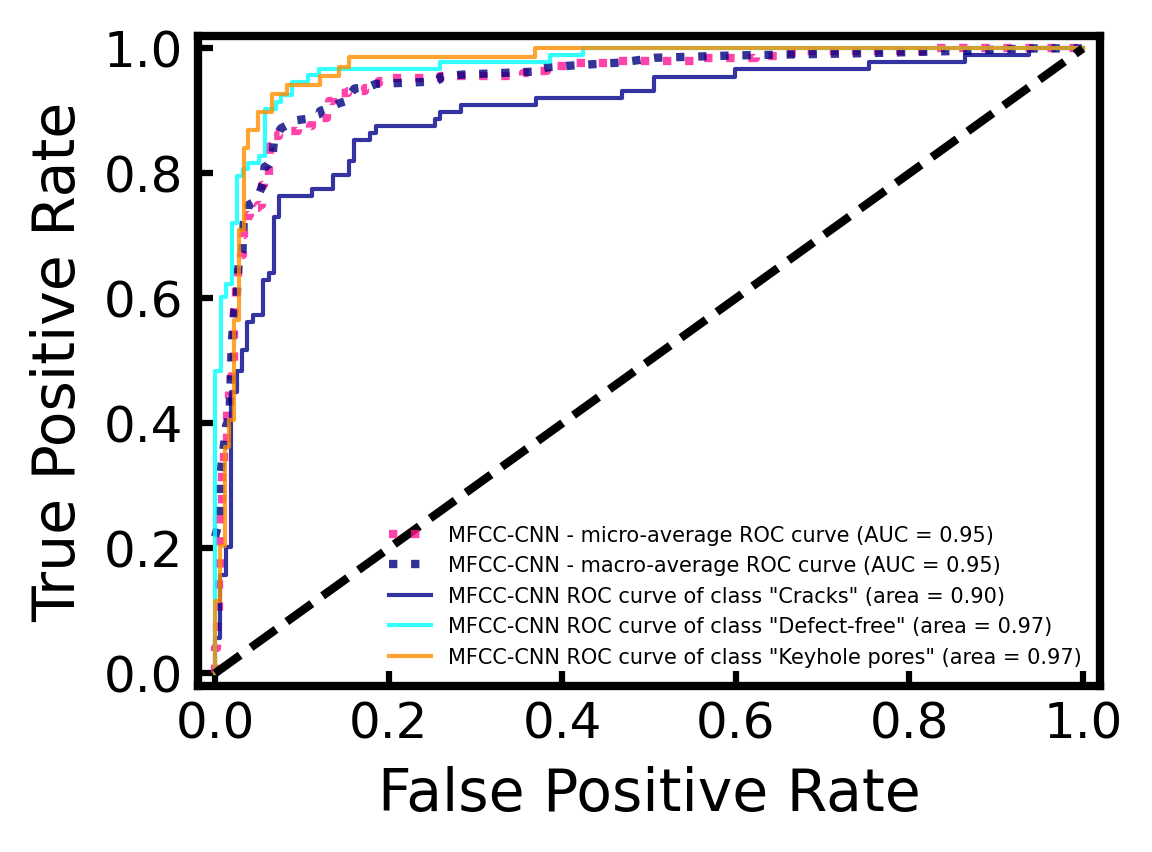

In [65]:
cnn_denoised_test_accuracy_mean, cnn_denoised_test_accuracy_std, cnn_denoised_auc_mean, cnn_denoised_auc_std= model_evaluation(model_optimal_MFCCCNN_denoised, 
                                                                                                               X_test_denoised, y_test_denoised, 
                                                                                                               classes=le.classes_, classifier_name = "MFCC-CNN", 
                                                                                                               signal_type = "denoised")

# Consolidate all the result

In [82]:
del original_auc_mean 
del equalized_auc_mean
del bandpassed_auc_mean
del denoised_auc_mean 

del original_auc_std 
del equalized_auc_std
del bandpassed_auc_std
del denoised_auc_std

del original_accuracy_mean_list 
del equalized_accuracy_mean_list
del bandpassed_accuracy_mean_list
del denoised_accuracy_mean_list 

del original_accuracy_std_list 
del equalized_accuracy_std_list
del bandpassed_accuracy_std_list
del denoised_accuracy_std_list

In [217]:
%store -r original_auc_mean 
%store -r equalized_auc_mean
%store -r bandpassed_auc_mean
%store -r denoised_auc_mean 

%store -r original_auc_std 
%store -r equalized_auc_std
%store -r bandpassed_auc_std
%store -r denoised_auc_std

%store -r original_accuracy_mean_list 
%store -r equalized_accuracy_mean_list
%store -r bandpassed_accuracy_mean_list
%store -r denoised_accuracy_mean_list 

%store -r original_accuracy_std_list 
%store -r equalized_accuracy_std_list
%store -r bandpassed_accuracy_std_list
%store -r denoised_accuracy_std_list

# %store -r df_accuracy
# %store -r df_auc

In [218]:
original_auc_mean_v2= original_auc_mean[:]
equalized_auc_mean_v2 = equalized_auc_mean[:]
bandpassed_auc_mean_v2= bandpassed_auc_mean[:]
denoised_auc_mean_v2= denoised_auc_mean[:]

original_auc_std_v2= original_auc_std[:]
equalized_auc_std_v2= equalized_auc_std[:]
bandpassed_auc_std_v2= bandpassed_auc_std[:]
denoised_auc_std_v2= denoised_auc_std[:]

original_accuracy_mean_list_v2= original_accuracy_mean_list[:]
equalized_accuracy_mean_list_v2= equalized_accuracy_mean_list[:]
bandpassed_accuracy_mean_list_v2= bandpassed_accuracy_mean_list[:]
denoised_accuracy_mean_list_v2= denoised_accuracy_mean_list[:]

original_accuracy_std_list_v2= original_accuracy_std_list[:]
equalized_accuracy_std_list_v2= equalized_accuracy_std_list[:]
bandpassed_accuracy_std_list_v2= bandpassed_accuracy_std_list[:]
denoised_accuracy_std_list_v2= denoised_accuracy_std_list[:]

In [219]:
original_auc_mean_v2.append(cnn_original_auc_mean)
equalized_auc_mean_v2.append(cnn_denoised_auc_mean)
bandpassed_auc_mean_v2.append(cnn_bandpassed_auc_mean)
denoised_auc_mean_v2.append(cnn_equalized_auc_mean)

original_auc_std_v2.append(cnn_original_auc_std)
equalized_auc_std_v2.append(cnn_equalized_auc_std)
bandpassed_auc_std_v2.append(cnn_denoised_auc_std)
denoised_auc_std_v2.append(cnn_bandpassed_auc_std)

In [220]:
original_accuracy_mean_list_v2.append(cnn_original_test_accuracy_mean)
equalized_accuracy_mean_list_v2.append(cnn_bandpassed_test_accuracy_mean)
bandpassed_accuracy_mean_list_v2.append(cnn_denoised_test_accuracy_mean)
denoised_accuracy_mean_list_v2.append(cnn_equalized_test_accuracy_mean)

original_accuracy_std_list_v2.append(cnn_original_test_accuracy_std)
equalized_accuracy_std_list_v2.append(cnn_bandpassed_test_accuracy_std)
bandpassed_accuracy_std_list_v2.append(cnn_denoised_test_accuracy_std)
denoised_accuracy_std_list_v2.append(cnn_equalized_test_accuracy_std)

In [221]:
%store original_auc_mean_v2 
%store equalized_auc_mean_v2
%store bandpassed_auc_mean_v2
%store denoised_auc_mean_v2 

%store original_auc_std_v2 
%store equalized_auc_std_v2
%store bandpassed_auc_std_v2
%store denoised_auc_std_v2

%store original_accuracy_mean_list_v2 
%store equalized_accuracy_mean_list_v2
%store bandpassed_accuracy_mean_list_v2
%store denoised_accuracy_mean_list_v2 

%store original_accuracy_std_list_v2 
%store equalized_accuracy_std_list_v2
%store bandpassed_accuracy_std_list_v2
%store denoised_accuracy_std_list_v2


Stored 'original_auc_mean_v2' (list)
Stored 'equalized_auc_mean_v2' (list)
Stored 'bandpassed_auc_mean_v2' (list)
Stored 'denoised_auc_mean_v2' (list)
Stored 'original_auc_std_v2' (list)
Stored 'equalized_auc_std_v2' (list)
Stored 'bandpassed_auc_std_v2' (list)
Stored 'denoised_auc_std_v2' (list)
Stored 'original_accuracy_mean_list_v2' (list)
Stored 'equalized_accuracy_mean_list_v2' (list)
Stored 'bandpassed_accuracy_mean_list_v2' (list)
Stored 'denoised_accuracy_mean_list_v2' (list)
Stored 'original_accuracy_std_list_v2' (list)
Stored 'equalized_accuracy_std_list_v2' (list)
Stored 'bandpassed_accuracy_std_list_v2' (list)
Stored 'denoised_accuracy_std_list_v2' (list)


In [222]:
denoised_auc_mean_v2

[0.8831685211345852,
 0.9098188917636229,
 0.8295027063062491,
 0.9099220647291313,
 0.9417945746892906,
 0.9293979460643482,
 0.9352708687163696,
 0.937572419485405,
 0.970341740607292]

In [223]:
models = ["DT","AdaBoost", "NB", "RF","KNN","LR","SVM", "GB", "MFCC-CNN" ]

In [224]:
def create_dataframe_metric_accuracy(mean_list, std_list, models, name):
    df = pd.DataFrame(mean_list)

    df.columns = ["value"]
    df["std"] = std_list
    df["models"] = models
    return df

df_original_accuracy = create_dataframe_metric_accuracy(original_accuracy_mean_list_v2,original_accuracy_std_list_v2, models, "original").sort_values(by="value", axis=0)
df_equalized_accuracy = create_dataframe_metric_accuracy(equalized_accuracy_mean_list_v2,equalized_accuracy_std_list_v2, models, "equalized" ).sort_values(by="value", axis=0)
df_bandpassed_accuracy = create_dataframe_metric_accuracy(bandpassed_accuracy_mean_list_v2,bandpassed_accuracy_std_list_v2, models, "bandpassed").sort_values(by="value", axis=0) 
df_denoised_accuracy = create_dataframe_metric_accuracy(denoised_accuracy_mean_list_v2, denoised_accuracy_std_list_v2, models, "denoised").sort_values(by="value", axis=0) 

In [225]:
df_accuracy = df_denoised_accuracy.merge(df_original_accuracy,on='models').merge(df_equalized_accuracy,on='models').merge(df_bandpassed_accuracy,on='models')
# df_accuracy = df_accuracy.merge(df_denoised_accuracy,on='models')
df_accuracy.columns = ["mean_denoised", "std_denoised","models", "mean_original", "std_original",
                      "mean_equalized", "std_equalized", "mean_bandpassed", "std_bandpassed"]
df_accuracy

/tmp/ipykernel_140197/1820014060.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'value_x', 'std_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_accuracy = df_denoised_accuracy.merge(df_original_accuracy,on='models').merge(df_equalized_accuracy,on='models').merge(df_bandpassed_accuracy,on='models')


,mean_denoised,std_denoised,models,mean_original,std_original,mean_equalized,std_equalized,mean_bandpassed,std_bandpassed
0,0.638693,0.015609,NB,0.575531,0.016853,0.603509,0.014380,0.635496,0.014263
1,0.695444,0.013706,RF,0.494005,0.007832,0.610711,0.009044,0.677858,0.024482
2,0.705001,0.027729,AdaBoost,0.637068,0.026740,0.686636,0.032686,0.678668,0.032539
3,0.749001,0.033306,DT,0.720224,0.020567,0.704237,0.014955,0.738609,0.015664
4,0.780985,0.025635,LR,0.748985,0.024984,0.731410,0.007897,0.753798,0.033421
5,0.811351,0.016421,SVM,0.784972,0.009855,0.742606,0.007913,0.777778,0.011134
6,0.818545,0.010784,KNN,0.772182,0.012228,0.800160,0.016653,0.812950,0.011910
7,0.827350,0.029794,GB,0.788943,0.019565,0.824947,0.030464,0.812159,0.017784
8,0.888392,0.046755,MFCC-CNN,0.840471,0.046028,0.836471,0.027318,0.864706,0.050635


In [226]:
# df_accuracy = df_accuracy.drop([df_accuracy.index[0], df_accuracy.index[9]])
df_accuracy

,mean_denoised,std_denoised,models,mean_original,std_original,mean_equalized,std_equalized,mean_bandpassed,std_bandpassed
0,0.638693,0.015609,NB,0.575531,0.016853,0.603509,0.014380,0.635496,0.014263
1,0.695444,0.013706,RF,0.494005,0.007832,0.610711,0.009044,0.677858,0.024482
2,0.705001,0.027729,AdaBoost,0.637068,0.026740,0.686636,0.032686,0.678668,0.032539
3,0.749001,0.033306,DT,0.720224,0.020567,0.704237,0.014955,0.738609,0.015664
4,0.780985,0.025635,LR,0.748985,0.024984,0.731410,0.007897,0.753798,0.033421
5,0.811351,0.016421,SVM,0.784972,0.009855,0.742606,0.007913,0.777778,0.011134
6,0.818545,0.010784,KNN,0.772182,0.012228,0.800160,0.016653,0.812950,0.011910
7,0.827350,0.029794,GB,0.788943,0.019565,0.824947,0.030464,0.812159,0.017784
8,0.888392,0.046755,MFCC-CNN,0.840471,0.046028,0.836471,0.027318,0.864706,0.050635


In [227]:
def create_dataframe_metric_auc(mean_list, std_list, models, name):
    df = pd.DataFrame(mean_list)

    df.columns = ["value"]
    df["std"] = std_list
    df["models"] = models
    return df

df_original_auc = create_dataframe_metric_accuracy(original_auc_mean_v2,original_auc_std_v2, models, "original").sort_values(by="value", axis=0)
df_equalized_auc = create_dataframe_metric_accuracy(equalized_auc_mean_v2,equalized_auc_std_v2, models, "equalized" ).sort_values(by="value", axis=0)
df_bandpassed_auc = create_dataframe_metric_accuracy(bandpassed_auc_mean_v2,bandpassed_auc_std_v2, models, "bandpassed").sort_values(by="value", axis=0) 
df_denoised_auc = create_dataframe_metric_accuracy(denoised_auc_mean_v2, denoised_auc_std_v2, models, "denoised").sort_values(by="value", axis=0) 

df_auc = df_denoised_auc.merge(df_original_auc,on='models').merge(df_equalized_auc,on='models').merge(df_bandpassed_auc,on='models')
# df_accuracy = df_accuracy.merge(df_denoised_accuracy,on='models')
df_auc.columns = ["mean_denoised", "std_denoised", "models", "mean_original", "std_original",
                      "mean_equalized", "std_equalized", "mean_bandpassed", "std_bandpassed"]
df_auc

/tmp/ipykernel_140197/2062959231.py:14: FutureWarning: Passing 'suffixes' which cause duplicate columns {'value_x', 'std_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_auc = df_denoised_auc.merge(df_original_auc,on='models').merge(df_equalized_auc,on='models').merge(df_bandpassed_auc,on='models')


,mean_denoised,std_denoised,models,mean_original,std_original,mean_equalized,std_equalized,mean_bandpassed,std_bandpassed
0,0.829503,0.0,NB,0.791329,0.0,0.792583,0.0,0.825233,0.0
1,0.883169,0.0,DT,0.863931,0.0,0.881895,0.0,0.868605,0.0
2,0.909819,0.0,AdaBoost,0.885252,0.0,0.907283,0.0,0.903136,0.0
3,0.909922,0.0,RF,0.880280,0.0,0.906061,0.0,0.909426,0.0
4,0.929398,0.0,LR,0.916192,0.0,0.891295,0.0,0.908359,0.0
5,0.935271,0.0,SVM,0.927977,0.0,0.899002,0.0,0.916525,0.0
6,0.937572,0.0,GB,0.939882,0.0,0.948128,0.0,0.938287,0.0
7,0.941795,0.0,KNN,0.929374,0.0,0.947560,0.0,0.948779,0.0
8,0.970342,0.0,MFCC-CNN,0.953255,0.0,0.946342,0.0,0.965374,0.0


In [228]:
df_accuracy["models"].to_list()

['NB', 'RF', 'AdaBoost', 'DT', 'LR', 'SVM', 'KNN', 'GB', 'MFCC-CNN']

Saving figure accuracy_summary


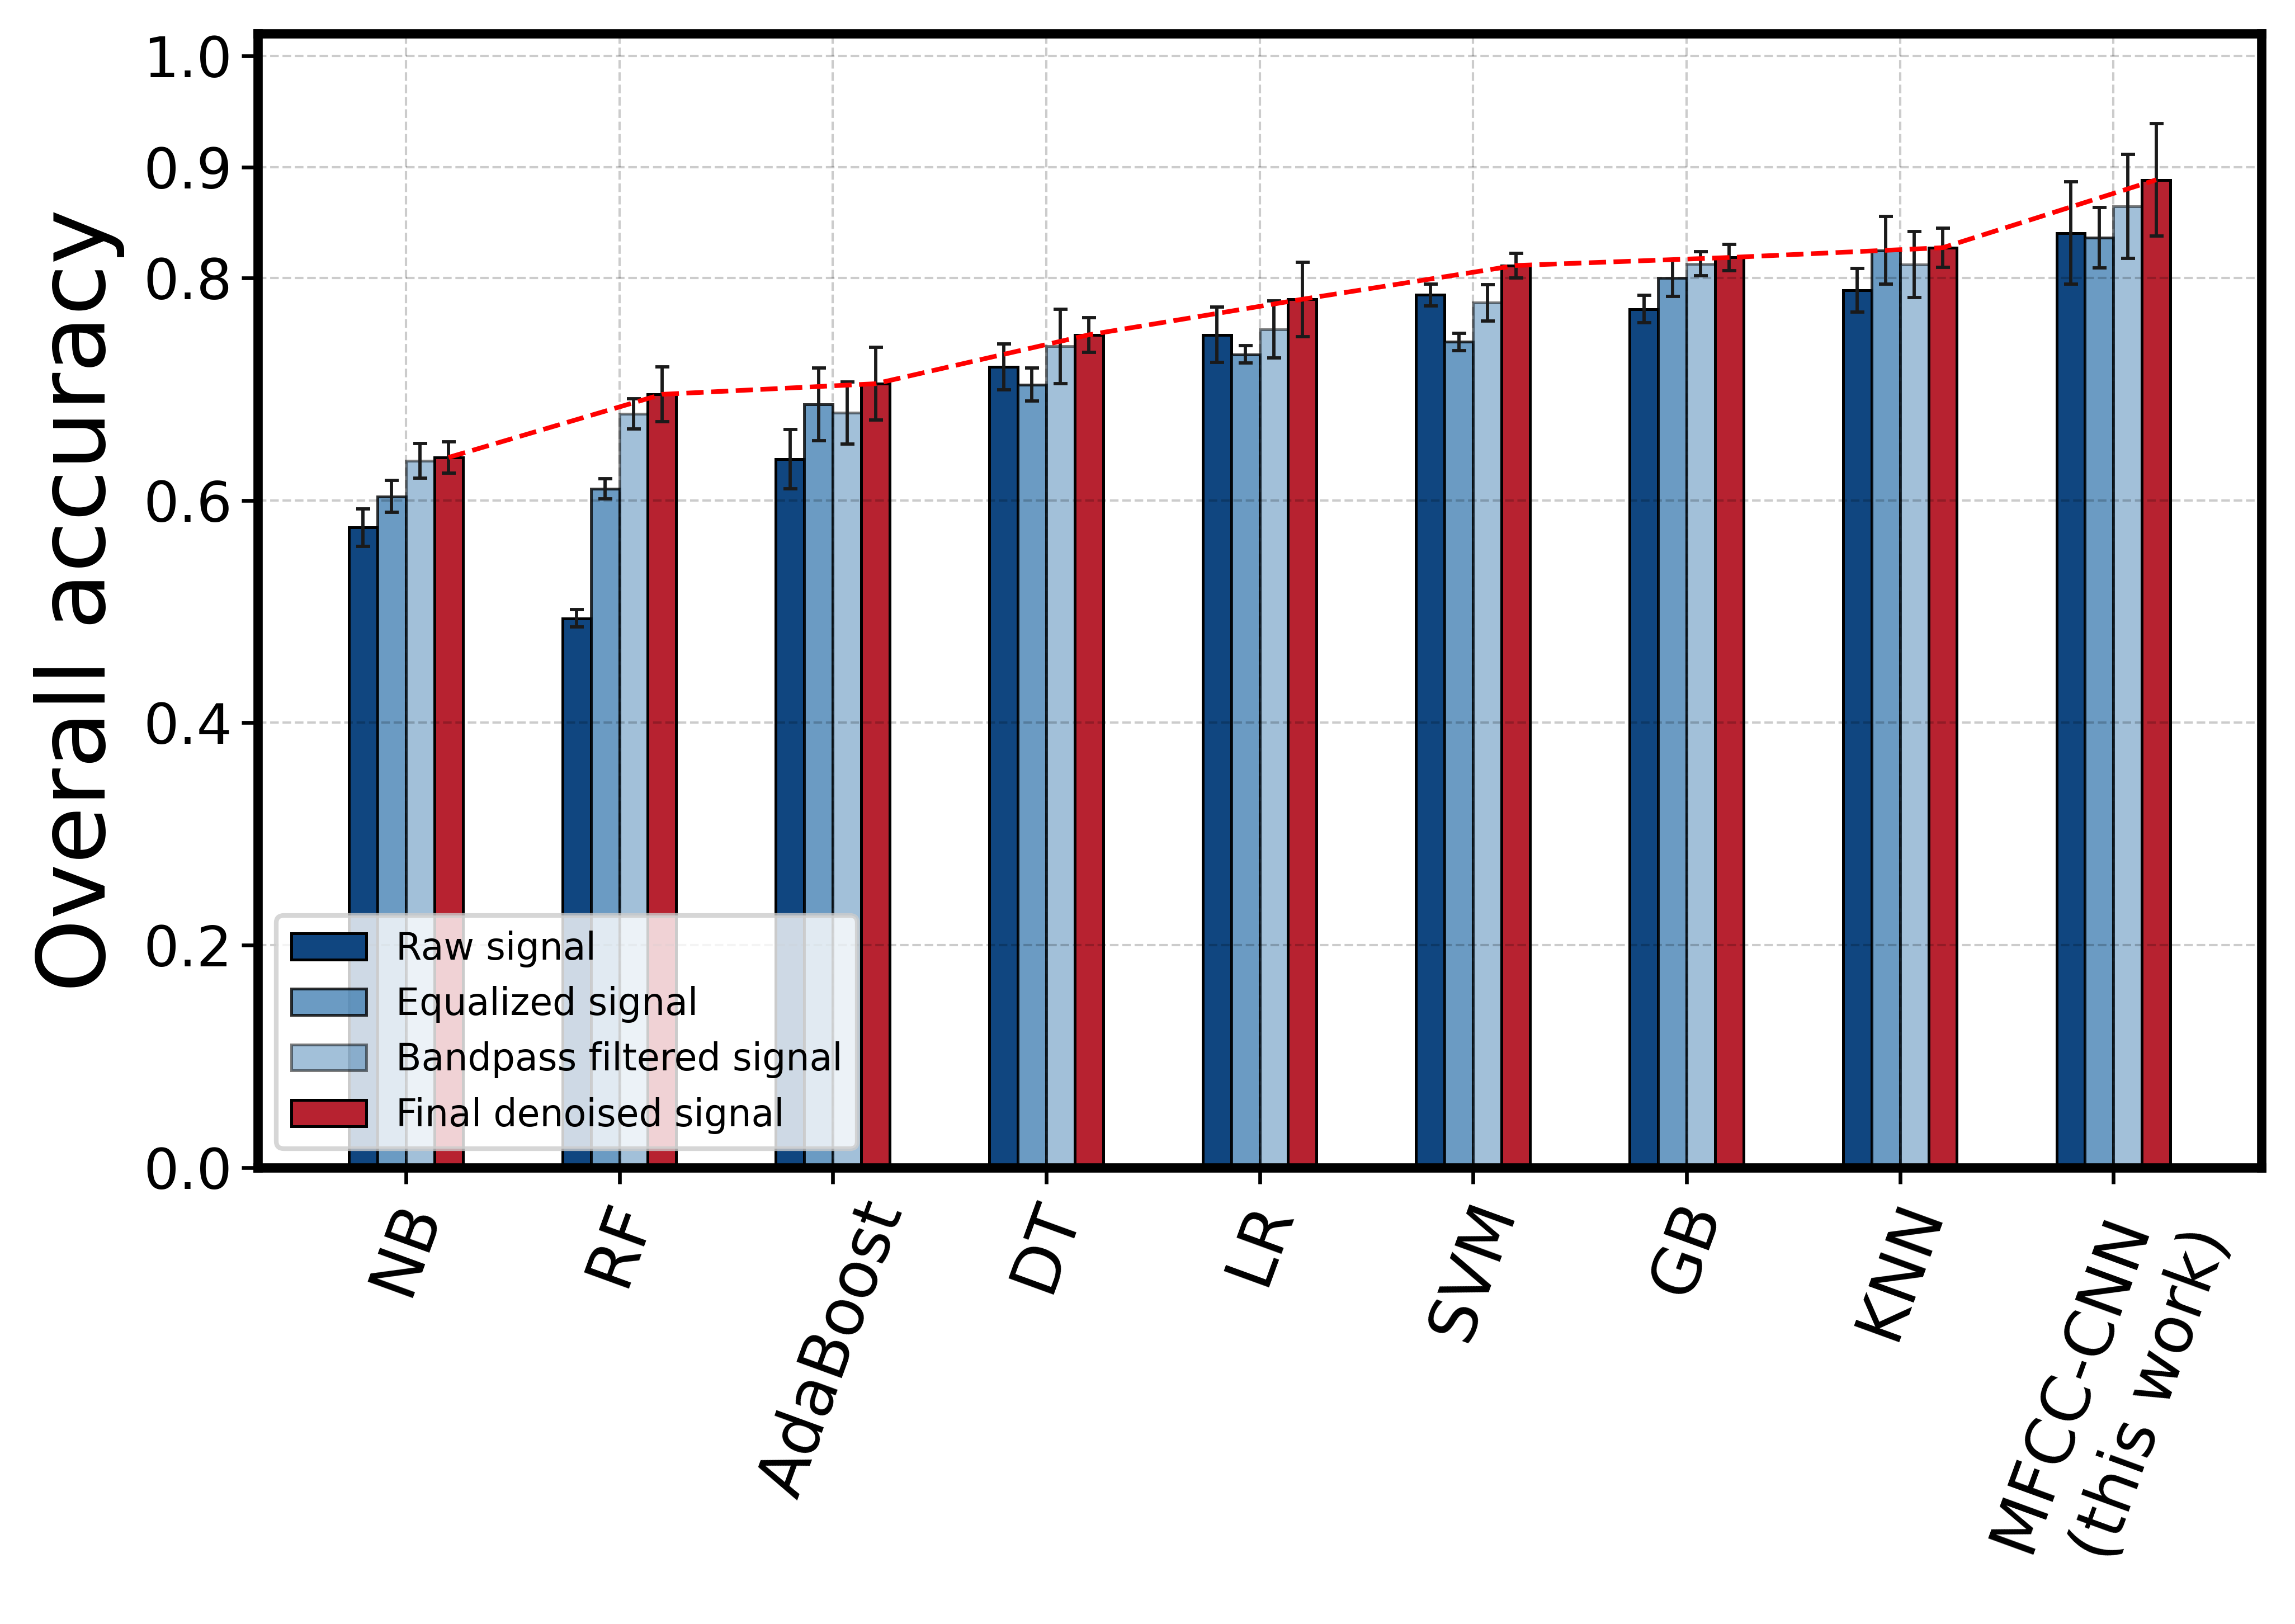

In [236]:
models = df_accuracy["models"].to_list()
models = ['NB', 'RF', 'AdaBoost', 'DT', 'LR', 'SVM', 'GB', 'KNN', 'MFCC-CNN \n (this work)']
x = np.arange(len(models))  # the label locations
width = 0.4
# the width of the bars

fig, ax = plt.subplots(figsize = (7,5), dpi= 600)
widths = 2
ax = gca()

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(widths)

    tick_width = 1.5
# plt.tick_params(direction = 'in', width = tick_width)


rects1 = ax.bar(3*x - 1.5*width, df_accuracy["mean_original"], width, yerr = df_accuracy["std_original"],error_kw = dict(ecolor= '0.1', lw=0.7, capsize=1.5, capthick=0.7), 
                 edgecolor ='k', linewidth=0.6, label='Raw signal', alpha =1 , color = '#104680') #, color = 'seagreen' (016, 070, 128) #104680
rects2 = ax.bar(3*x - 0.5*width, df_accuracy["mean_equalized"], width, yerr = df_accuracy["std_equalized"] , error_kw = dict(ecolor= '0.1', lw=0.7, capsize=1.5, capthick=0.7),
                 edgecolor ='k', linewidth=0.6, label='Equalized signal', alpha = 0.8, color = 'steelblue') # color = 'wheat' (109,173, 209) #6DADD1
rects3 = ax.bar(3*x + 0.5*width, df_accuracy["mean_bandpassed"], width, yerr = df_accuracy["std_denoised"] , error_kw = dict(ecolor= '0.1', lw=0.7, capsize=1.5, capthick=0.7),
                 edgecolor ='k', linewidth=0.6, label='Bandpass filtered signal', alpha = 0.5,  color = 'steelblue') #,  color = 'steelblue' (233, 241, 244) #E9F1F4
rects4 = ax.bar(3*x + 1.5*width, df_accuracy["mean_denoised"], width, yerr = df_accuracy["std_bandpassed"] , error_kw = dict(ecolor= '0.1', lw=0.7, capsize=1.5, capthick=0.7),
                 edgecolor ='k', linewidth=0.6, label='Final denoised signal', alpha = 1,  color = "#B72230") #f03b1a ,  color = 'darkorange' (183, 034, 048)--> B72230 

ax.plot(3*x + 1.5*width, df_accuracy["mean_denoised"], "r--", linewidth =1)
# original colorlist: midnightblue, red, steelblue, olive

ax.set_ylabel('Overall accuracy',fontsize = 20)
#ax.set_title('depth regression task, test set accuracy')
ax.set_xticks(3*x)

plt.xticks(fontsize=14,  rotation=70, ha='center')
ax.tick_params(axis="y",direction="out", pad= 2)
ax.tick_params(axis="x",direction="out", pad= 2)

ax.set_xticklabels(models)
ax.set_ylim([0, 1.02])
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 0.9,1.0])
ax.legend(loc = 'lower left',  fontsize = '8', framealpha = 0.8)

ax.grid(zorder=3, linestyle='--',linewidth=0.5, alpha=0.2, color = "k") #linestyle='--', color='r'

fig.tight_layout()
# plt.show()
save_fig("accuracy_summary")

Saving figure AUC_ROC summary


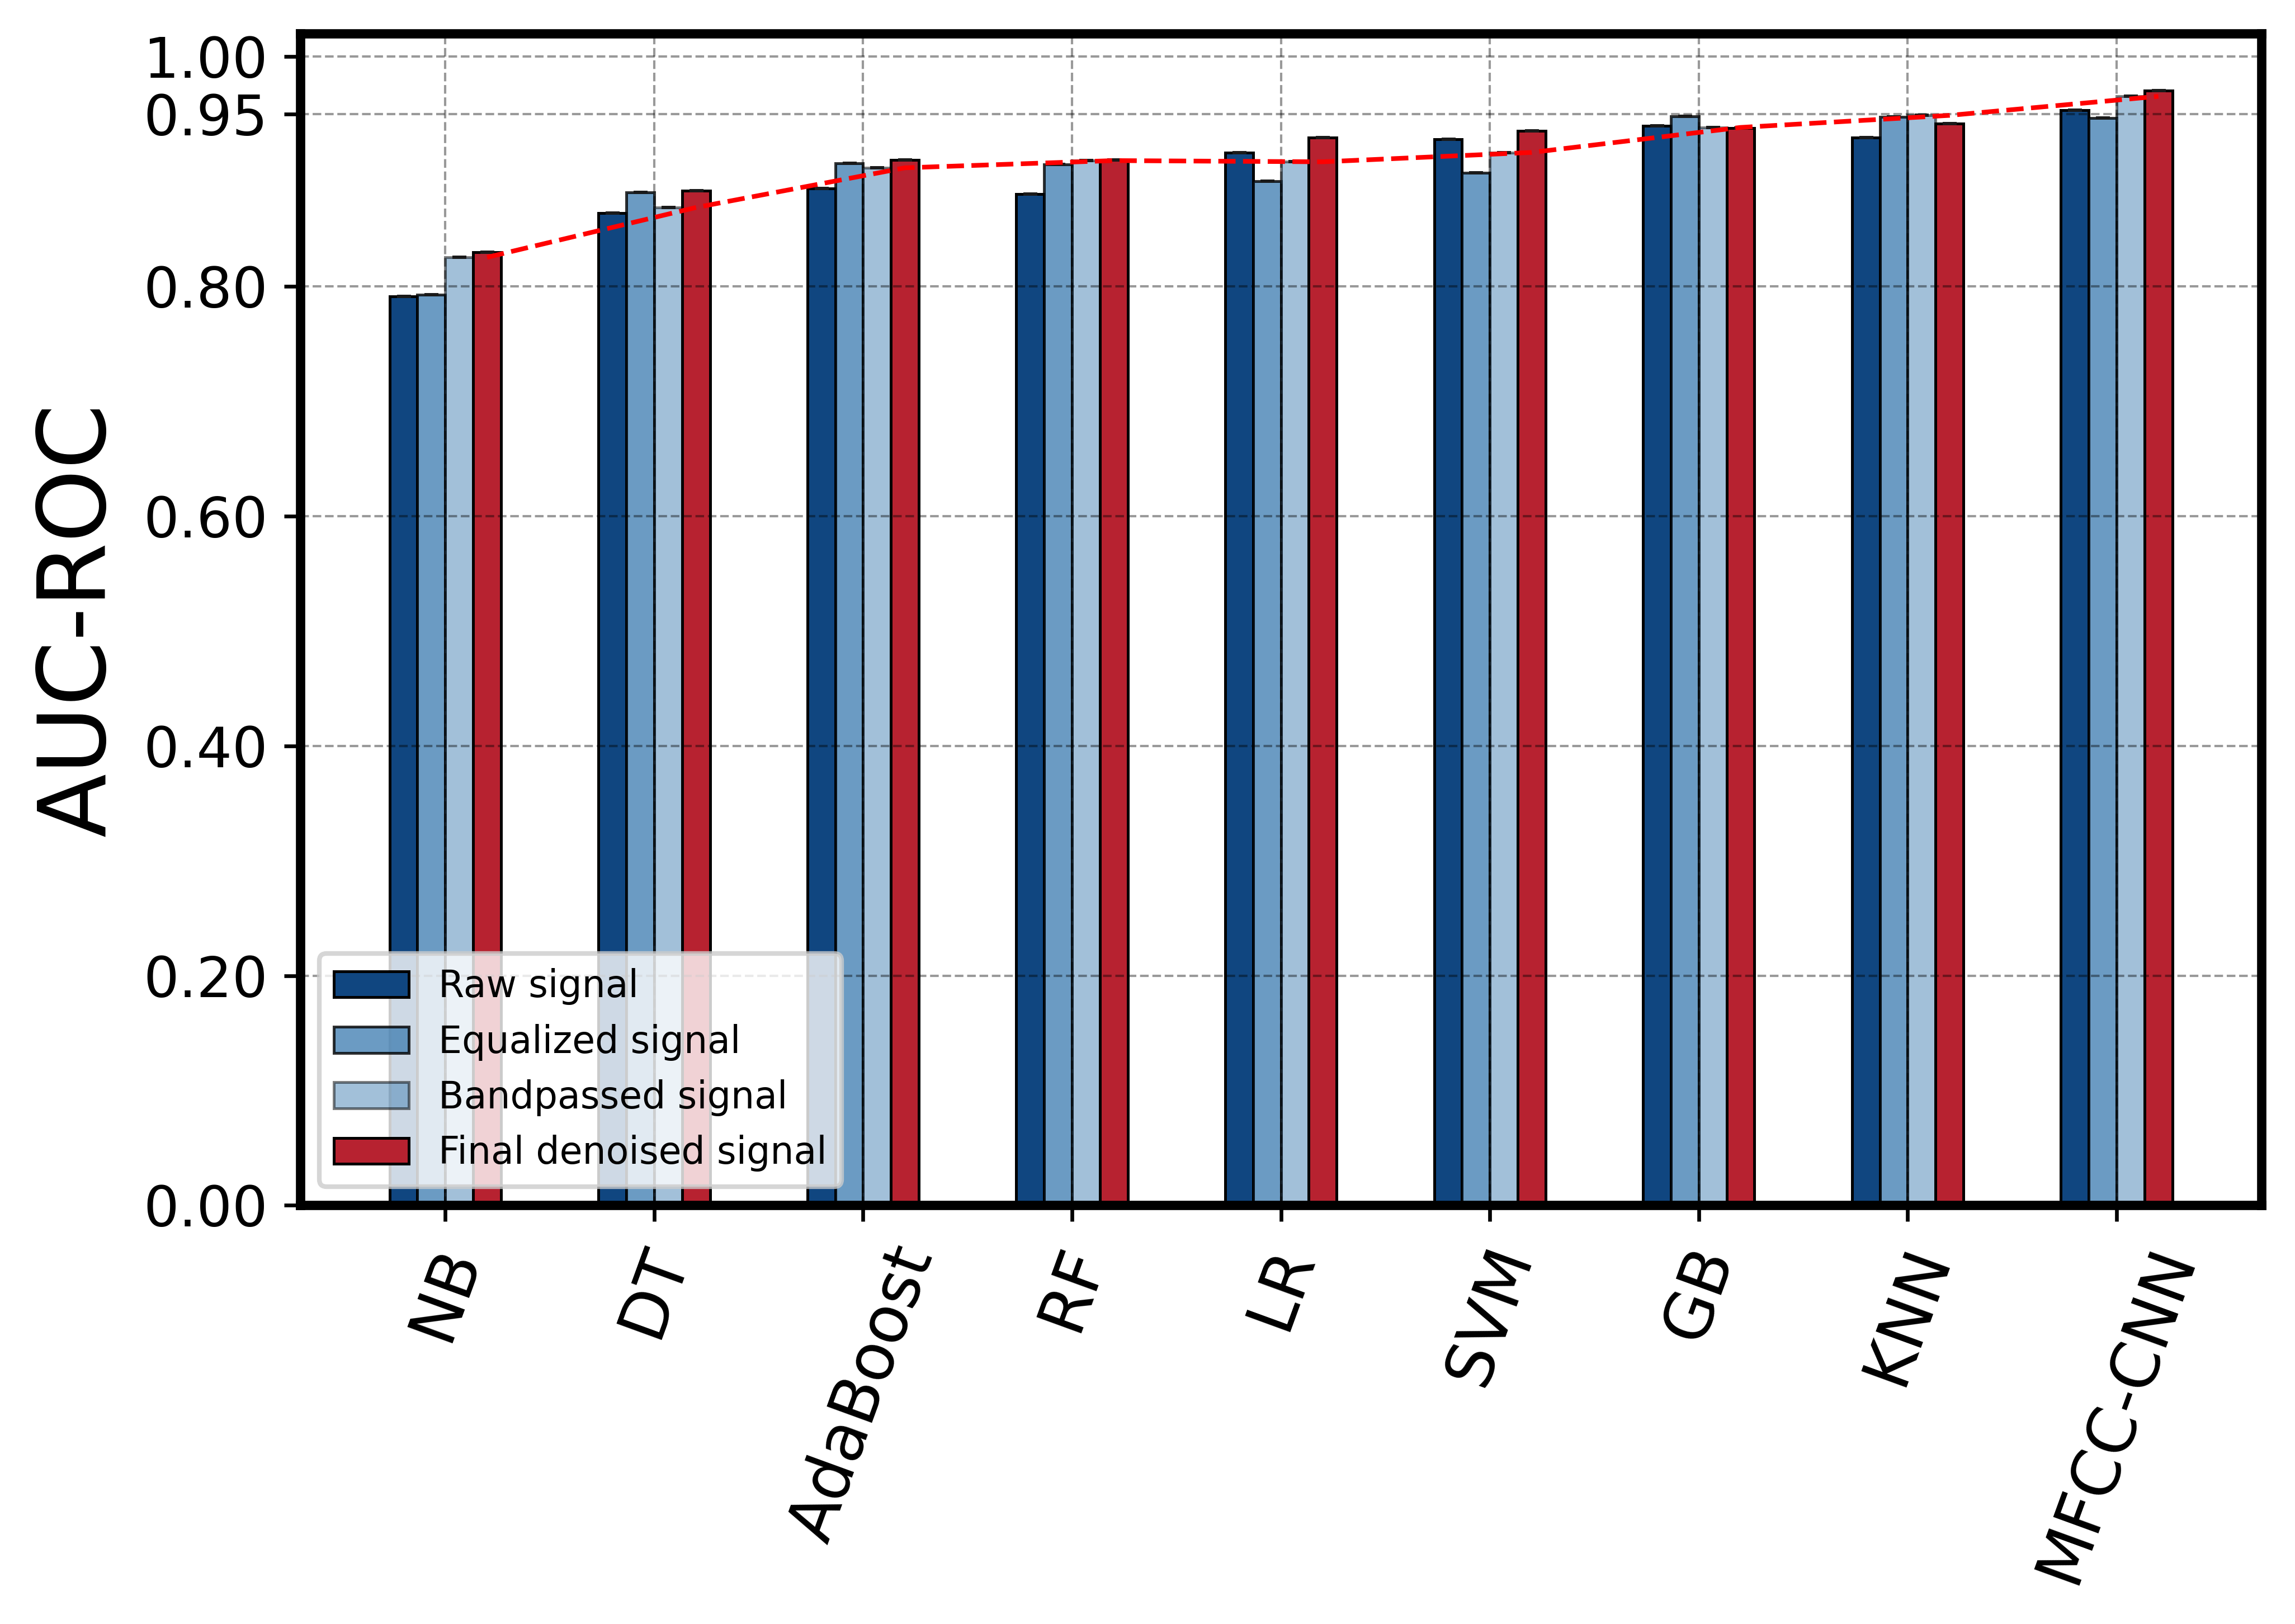

In [235]:
models = df_auc["models"].to_list()

x = np.arange(len(models))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize = (7,5), dpi = 600)
widths = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(widths)

    tick_width = 1.5
# plt.tick_params(direction = 'in', width = tick_width)


rects1 = ax.bar(3*x - 1.5*width, df_auc["mean_original"], width, yerr = df_auc["std_original"],error_kw = dict(ecolor= '0.1', lw=0.7, capsize=1.5, capthick=0.7), 
                 edgecolor ='k', linewidth=0.6, label='Raw signal', alpha =1 , color = '#104680') #, color = 'seagreen' (016, 070, 128) #104680
rects2 = ax.bar(3*x - 0.5*width, df_auc["mean_equalized"], width, yerr = df_auc["std_equalized"] , error_kw = dict(ecolor= '0.1', lw=0.7, capsize=1.5, capthick=0.7),
                 edgecolor ='k', linewidth=0.6, label='Equalized signal', alpha = 0.8, color = 'steelblue') # color = 'wheat' (109,173, 209) #6DADD1
rects3 = ax.bar(3*x + 0.5*width, df_auc["mean_bandpassed"], width, yerr = df_auc["std_denoised"] , error_kw = dict(ecolor= '0.1', lw=0.7, capsize=1.5, capthick=0.7),
                 edgecolor ='k', linewidth=0.6, label='Bandpassed signal', alpha = 0.5,  color = 'steelblue') #,  color = 'steelblue' (233, 241, 244) #E9F1F4
rects4 = ax.bar(3*x + 1.5*width, df_auc["mean_denoised"], width, yerr = df_auc["std_bandpassed"] , error_kw = dict(ecolor= '0.1', lw=0.7, capsize=1.5, capthick=0.7),
                 edgecolor ='k', linewidth=0.6, label='Final denoised signal', alpha = 1,  color = "#B72230") #f03b1a ,  color = 'darkorange' (183, 034, 048)--> B72230 


ax.set_ylabel('AUC-ROC', fontsize = 20)

ax.plot(3*x + 1.5*width, df_auc["mean_bandpassed"], "r--", linewidth =1)

#ax.set_title('depth regression task, test set accuracy')
ax.set_xticks(3*x)
ax.set_xticklabels(models)
ax.set_ylim([0, 1.02])

ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8 ,0.95,1.0])
ax.legend(loc = 'lower left',  fontsize = '8', framealpha = 0.8)
plt.xticks(fontsize=14,  rotation=70, ha='center')

fig.tight_layout()
# plt.show()
ax.grid(zorder=3, linestyle='--',linewidth=0.5, alpha=0.4, color = "k") #linestyle='--', color='r'

save_fig("AUC_ROC summary")

### Defect prediction accuracy comparison

In [ ]:
# original [NB, DT, AaBoost, LR, RF, SVM, GB, KNN, MFCC-CNN]
keyhole_prediction_original = []